*In this file, we seek to run and compare various scenarios*

In [10]:
import subprocess
import os
from pathlib import Path
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import re
from gdxpds import to_dataframes
import numpy as np
import seaborn as sns

# Define paths
gams_model = "osemosys.gms"
results_folder = Path("Results")
results_folder.mkdir(exist_ok=True)

scenario = "parametrised_py"
data = "template"
storage = "yes"  # or "no"

*Remember to change the path to your own gams executable in the next codeblock (line 2), found by typing 'where gams' into a terminal*

In [11]:
#user-defined declarations
###### TO CHANGE ######
results_folder = "Results" #path to results folder
osemosys_exe = os.path.join(os.getcwd(),"osemosys.gms") #path to OSeMOSYS model

#######################

selected_files = [["SSP1", "template", "yes"],
                  ["SSP2", "template", "yes"],
                  ["SSP3", "template", "yes"],
                  ["SSP4", "template", "yes"],
                  ["SSP5", "template", "yes"]] #

def extract_results(selected_files = None):
    """
    For each (scen, data, stor) in selected_files, load the corresponding file and return
    a list of OrderedDicts (from to_dataframes), in the same order as selected_files.
    """
    print("Loading results...")
    results = []
    results_dir = os.path.join(os.getcwd(), results_folder)
    pattern = re.compile(r"results_SCEN(?P<scen>\w+)_DATA(?P<data>\w+)_STOR(?P<stor>yes|no)\.gdx")

    file_lookup = {}
    for filename in os.listdir(results_dir):
        match = pattern.match(filename)
        if match:
            key = (match.group("scen"), match.group("data"), match.group("stor"))
            file_lookup[key] = os.path.join(results_dir, filename)
    
    if selected_files is not None:
        for triplet in selected_files:
            key = tuple(triplet)
            if key in file_lookup:
                filename = file_lookup[key]
                print(filename)
                results.append(to_dataframes(filename))
            else:
                print(f"{key} not found")
                results.append(None)

        return results
    else:
        for key, filename in file_lookup.items():
            print(filename)
            results.append(to_dataframes(filename))
        return results  

In [36]:
sns.set_theme(style="whitegrid", font_scale=1.3)
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict

def plot_name(dictList, name, x_col, y_col, target, title=None, xlabel=None, ylabel=None):
    dfList = []
    for i in range(0, len(dictList)):
        dfList.append(dictList[i][name])
    

    all_targets = sorted(set().union(*[df[target].unique() for df in dfList]))
    palette = sns.color_palette("tab20", n_colors=len(dfList[0][target].unique()))
    colour_map = dict(zip(all_targets, palette))

    n = len(dfList)
    ncols = 2
    nrows = (n+1)//ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*5), sharey=True, sharex=True)
    axes = axes.flatten()
    for i,df in enumerate(dfList):
        ax = axes[i]

        df = df.pivot_table(index='YEAR', columns=target, values='Level', aggfunc='sum', fill_value=0)

        for col in df.columns:
            if (df[col] != 0).any():
                ax.plot(df.index, df[col], label=col, color=colour_map[col], linewidth=2)

        ax.set_title(f"{title if title else name} - Case {i+1}", fontsize=14)
        ax.set_xlabel(xlabel if xlabel else x_col)
        ax.set_ylabel(ylabel if ylabel else y_col)
        ax.grid(True)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce overcrowding on x-axis
        ax.tick_params(axis='x', rotation=45)
        
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    by_label = OrderedDict(zip(labels, handles))

    # Place legend on the right outside plot
    fig.legend(
        by_label.values(), by_label.keys(),
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0.,
        frameon=True,
        framealpha=0.6
    )

# Add some padding between plot and legend
    plt.subplots_adjust(right=0.85)

    #handles, labels = axes[0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4, frameon=False, framealpha=0.4)


    fig.tight_layout()
    #fig.suptitle(title if title else f"{y_col} vs {x_col}", fontsize=16)
        
    plt.show()

def plot_allusefulcharts(dictList, filter=None):
    x_col = "YEAR"
    y_col = "Level"

    TechnologyPlots = ["ProductionByTechnology", "RateOfProductionByTechnology", "UseByTechnologyAnnual", "RateOfTotalActivity", "OperatingCost", "AnnualTechnologyEmission", "AccumulatedNewCapacity"]
    FuelPlots = ["RateOfUse", "Trade", "UseAnnual", "Demand"]
    StoragePlots = ["NewStorageCapacity", "CapitalInvestmentStorage", "TotalDiscountedStorageCost", "AccumulatedNewStorageCapacity", "StorageLevelYearStart"]
    EmissionPlots = ["AnnualEmissions"]
    
    for t in TechnologyPlots:
        if filter!= None and t not in filter:
            continue
        #df = gdx_f[t]
        #df = df[df["Level"] > 0]
        plot_name(dictList, t, x_col=x_col, y_col=y_col, target="TECHNOLOGY", title=t)

    for f in FuelPlots:
        if filter != None and f not in filter:
            continue
        #df = gdx_f[f]
        #df = df[df["Level"] > 0]
        plot_name(dictList, f, x_col=x_col, y_col=y_col, target="FUEL", title=f)

    for s in StoragePlots:
        if filter != None and s not in filter:
            continue
        #df = gdx_f[s]
        #df = df[df["Level"] > 0]
        plot_name(dictList, s, x_col=x_col, y_col=y_col, target="STORAGE", title=s)

    for e in EmissionPlots:
        if filter != None and e not in filter:
            continue
        #df = gdx_f[e]
        #df = df[df["Level"] > 0]
        plot_name(dictList, e, x_col=x_col, y_col=y_col,target="EMISSION", title=e)

def run_extr_gams(selected_files, solvermode="mip"):
    for file in selected_files:
        scenario, data, storage = file
        print(scenario, data, storage)
        subprocess.run([
            "gams",
            gams_model,
            f"--scen={scenario}",
            f"--data={data}",
            f"--storage={storage}"
            f"--solvermode={solvermode}"], check=True)
    
    res = extract_results(selected_files)
    return res


In [37]:
selected_files = [["SSP1", "template", "yes"],
                  ["SSP2", "template", "yes"],
                  ["SSP3", "template", "yes"],
                  ["SSP4", "template", "yes"],
                  ["SSP5", "template", "yes"]]

SSP1 template yes
--- Job osemosys.gms Start 05/19/25 14:39:20 49.2.0 9b2b0844 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/GAMS.framework/Versions/49/Resources/gmsprmun.txt
--- GAMS Parameters defined
    Input /Users/hugosmart/Documents/Github/Hy-run/osemosys.gms
    ScrDir /Users/hugosmart/Documents/Github/Hy-run/225d/
    SysDir /Library/Frameworks/GAMS.framework/Versions/49/Resources/
    --scen SSP1
    --data template
    --storage yes--solvermode=mip
Licensee: Massimo Tavoni                                 G250226+0003Ac-GEN
          Fondazione CMCC                                           DCE4109
          225d/gamslice.dat
          node:56901401 mem:8 cores:8 ipport:49585 v:2                     
          Course license for use within the course and related course work
          The expiration date of time-limited license is Sep 24, 2025
System information: 8 physical cores and 8 Gb memory detected
GAMS 49.2.0   Copyright (C) 1987-2025 GAMS Development. A

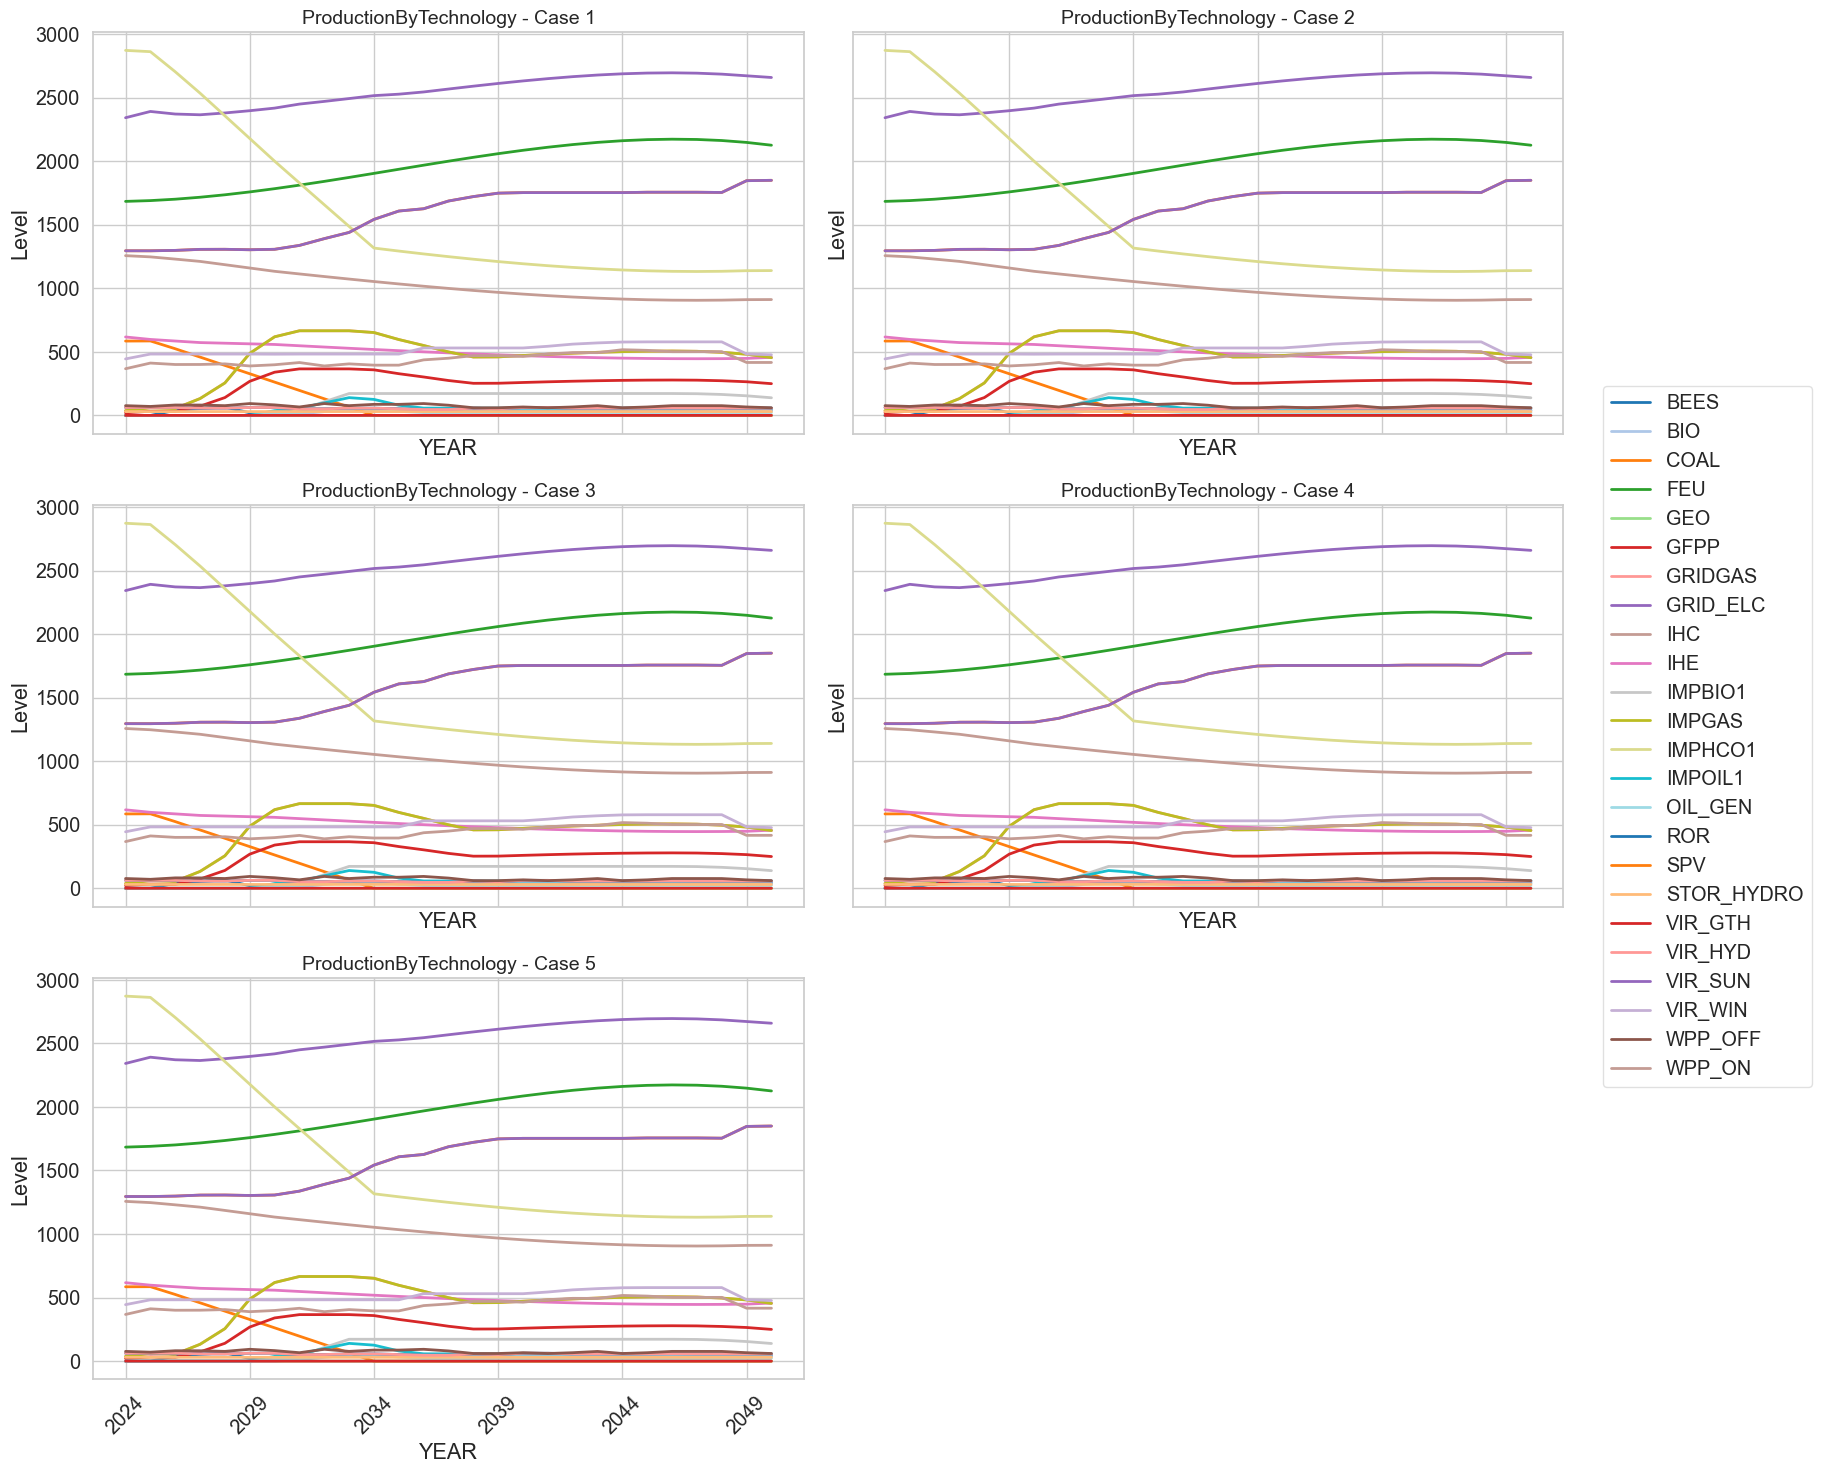

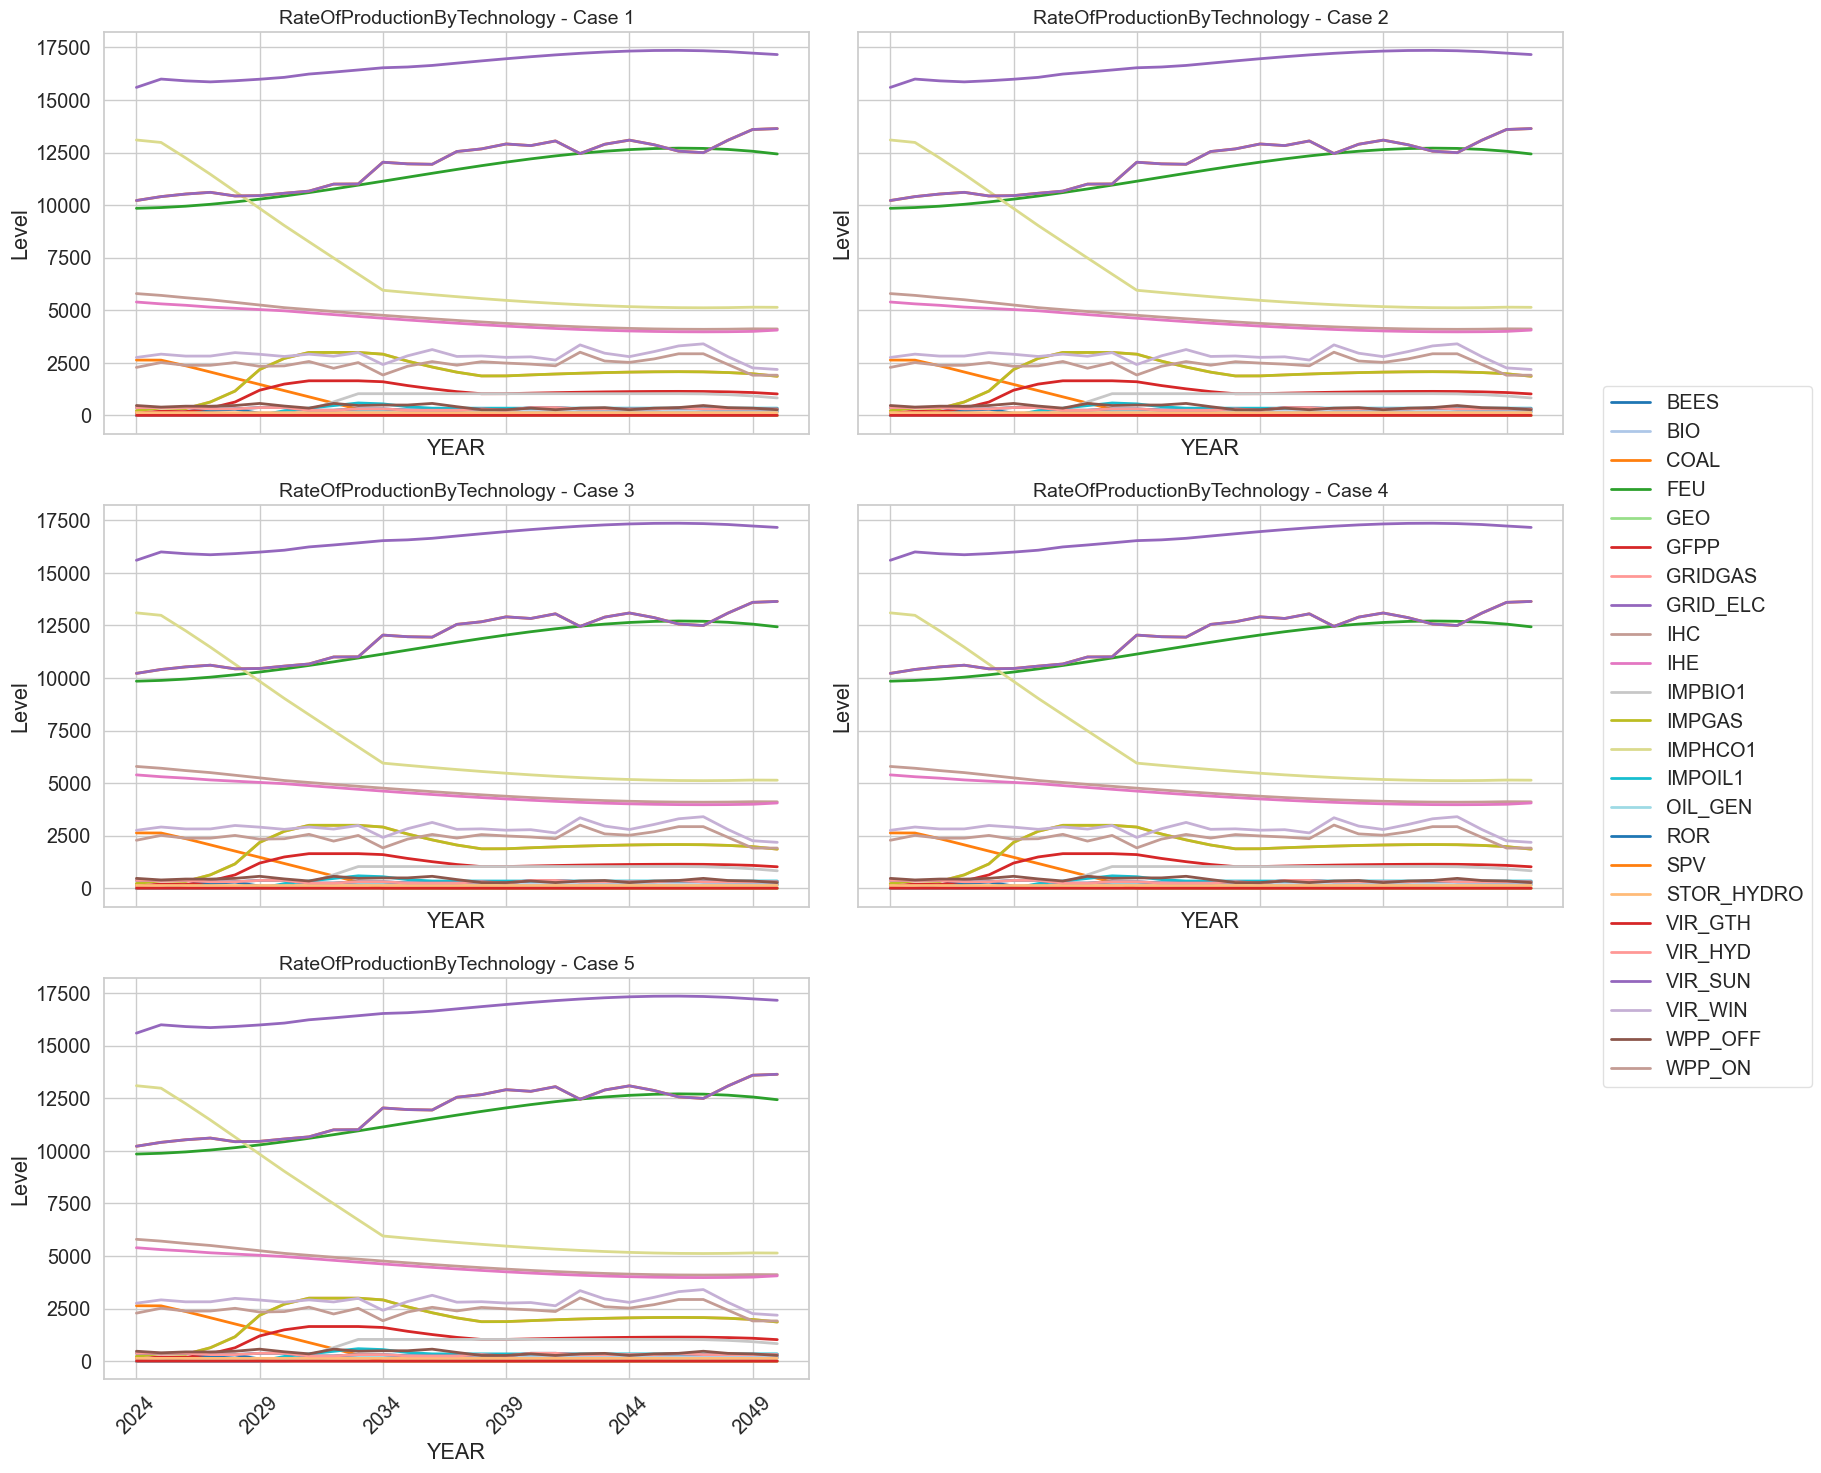

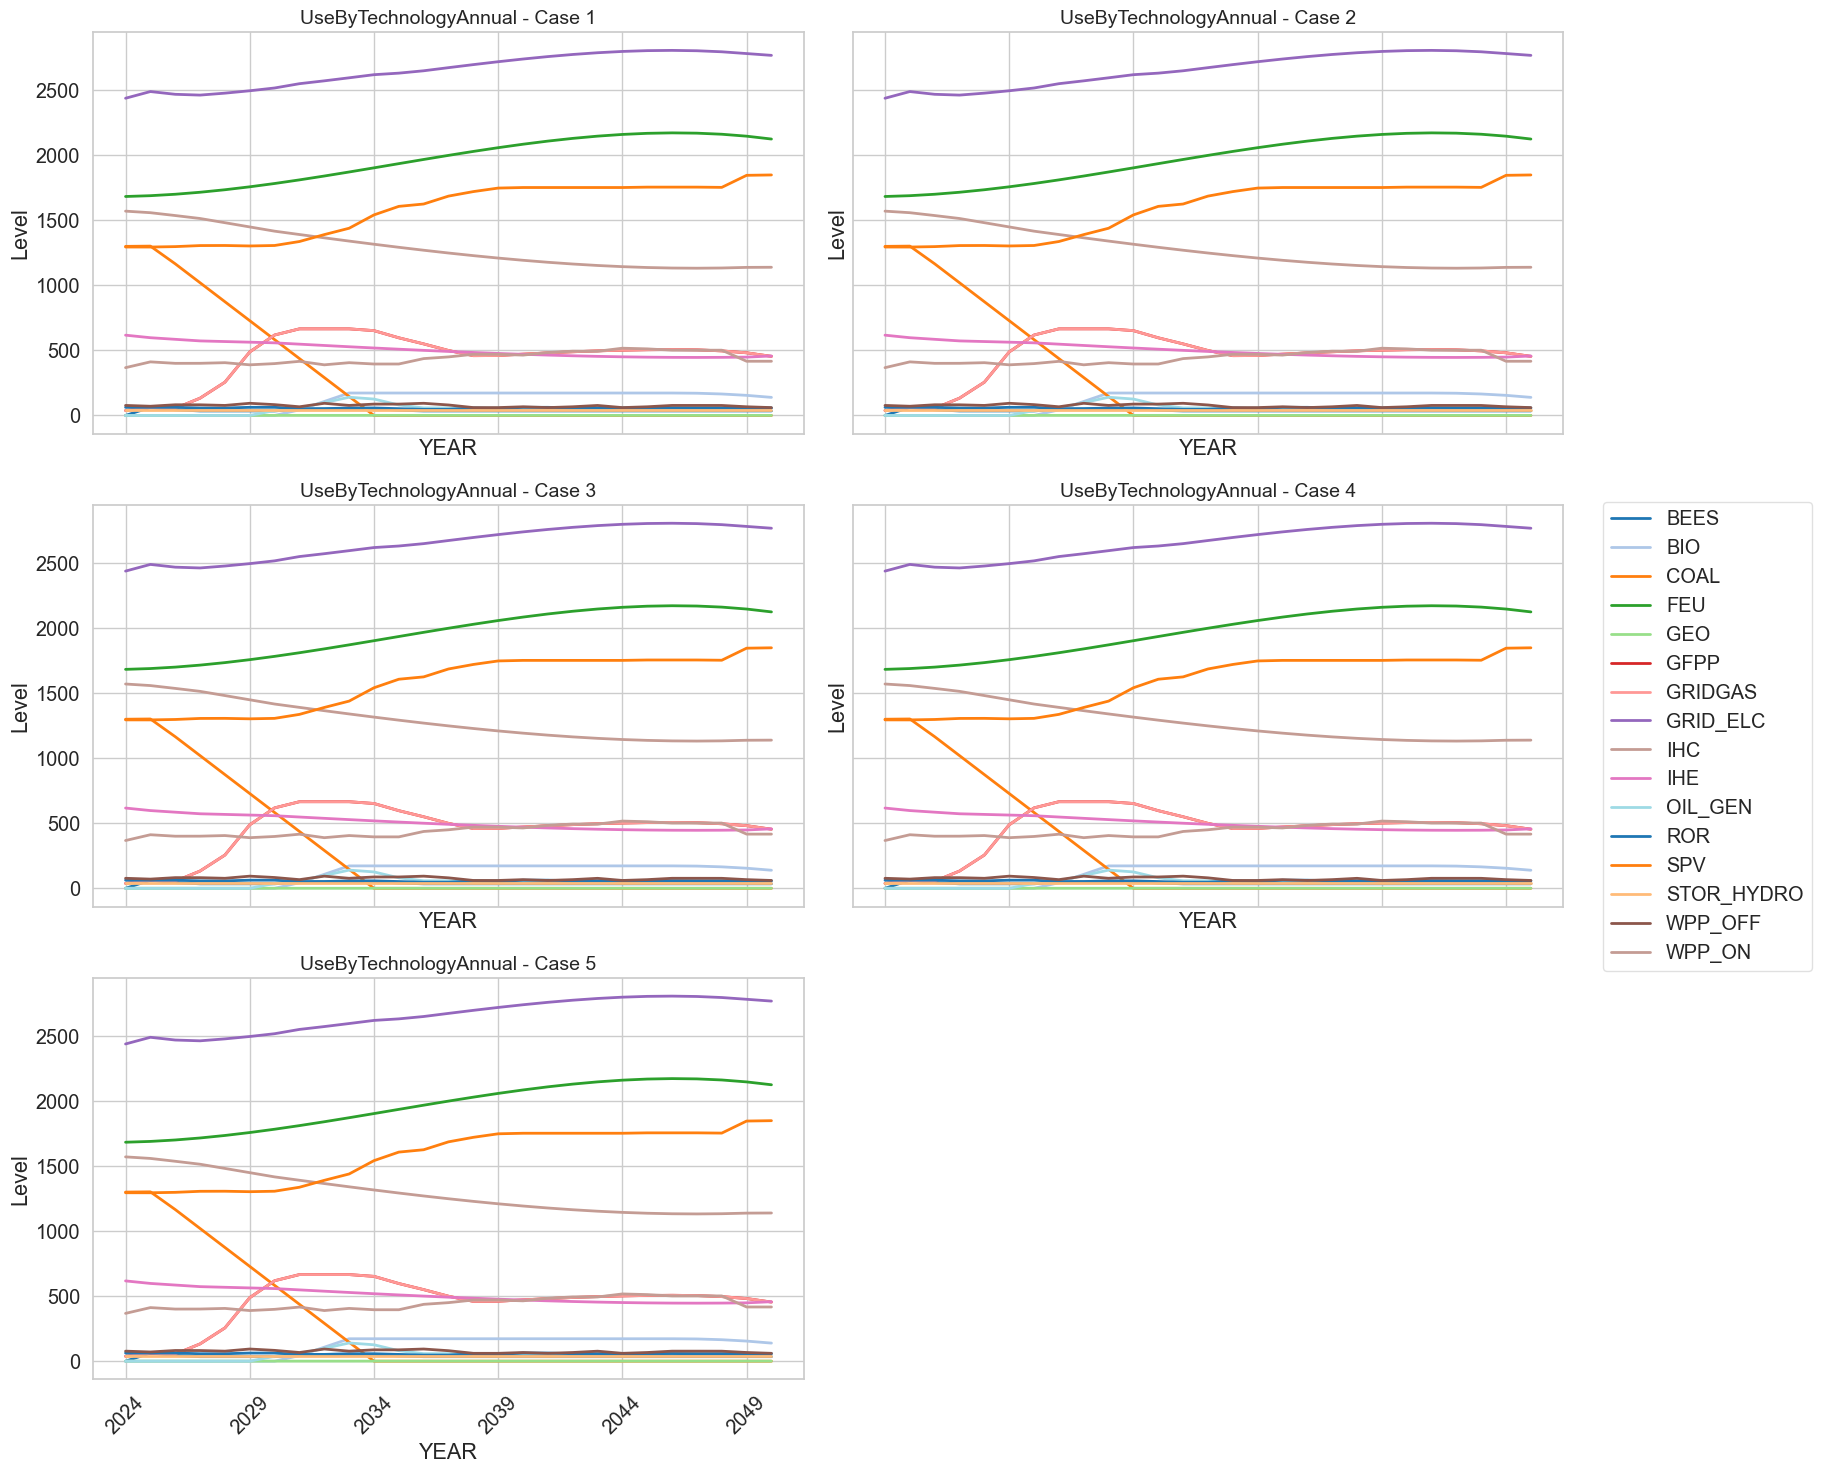

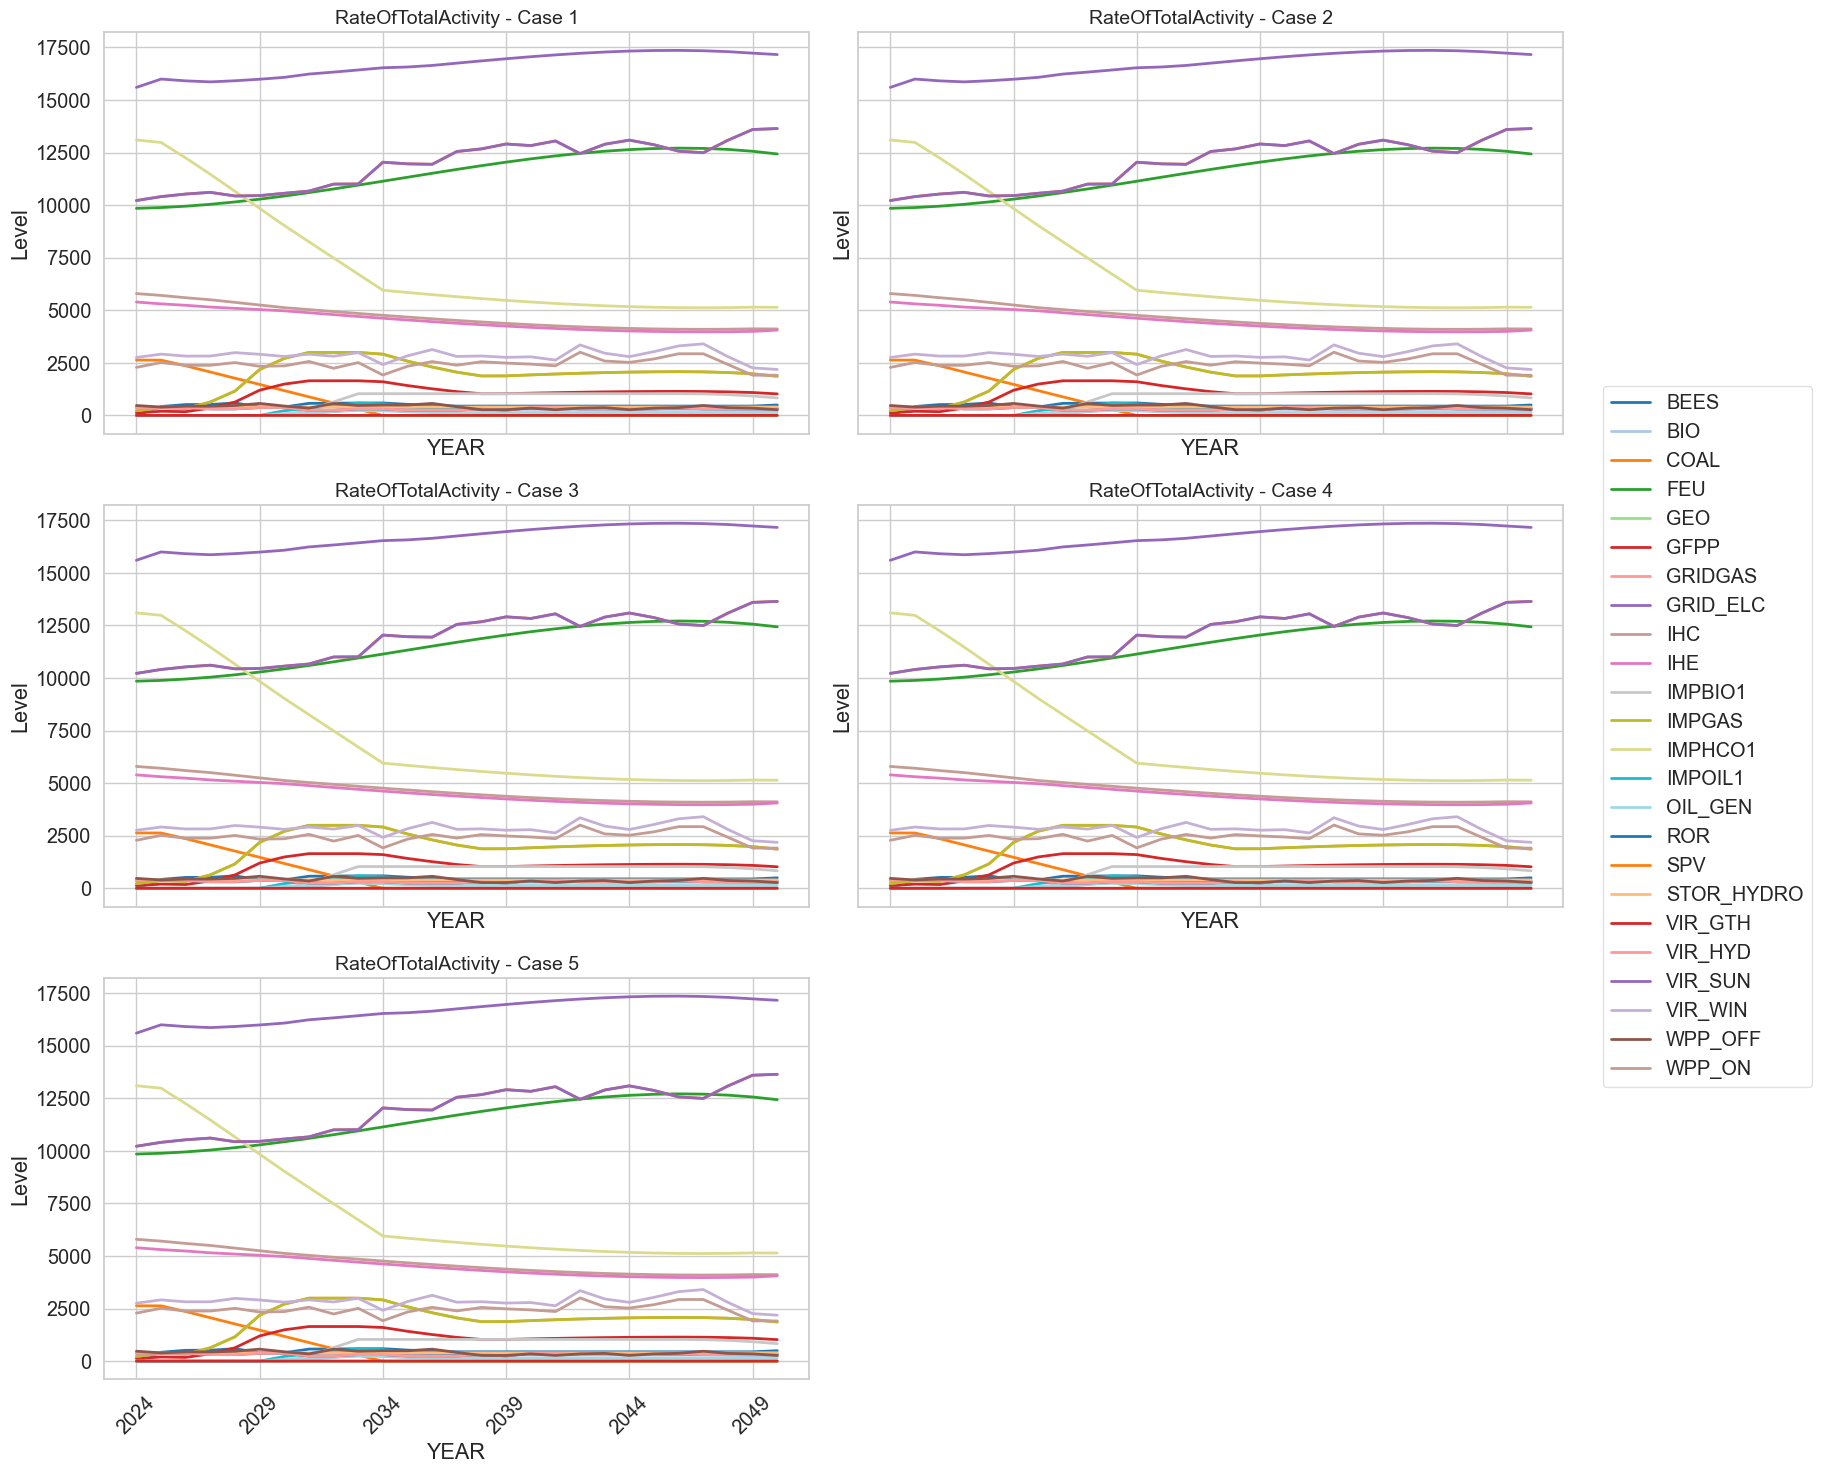

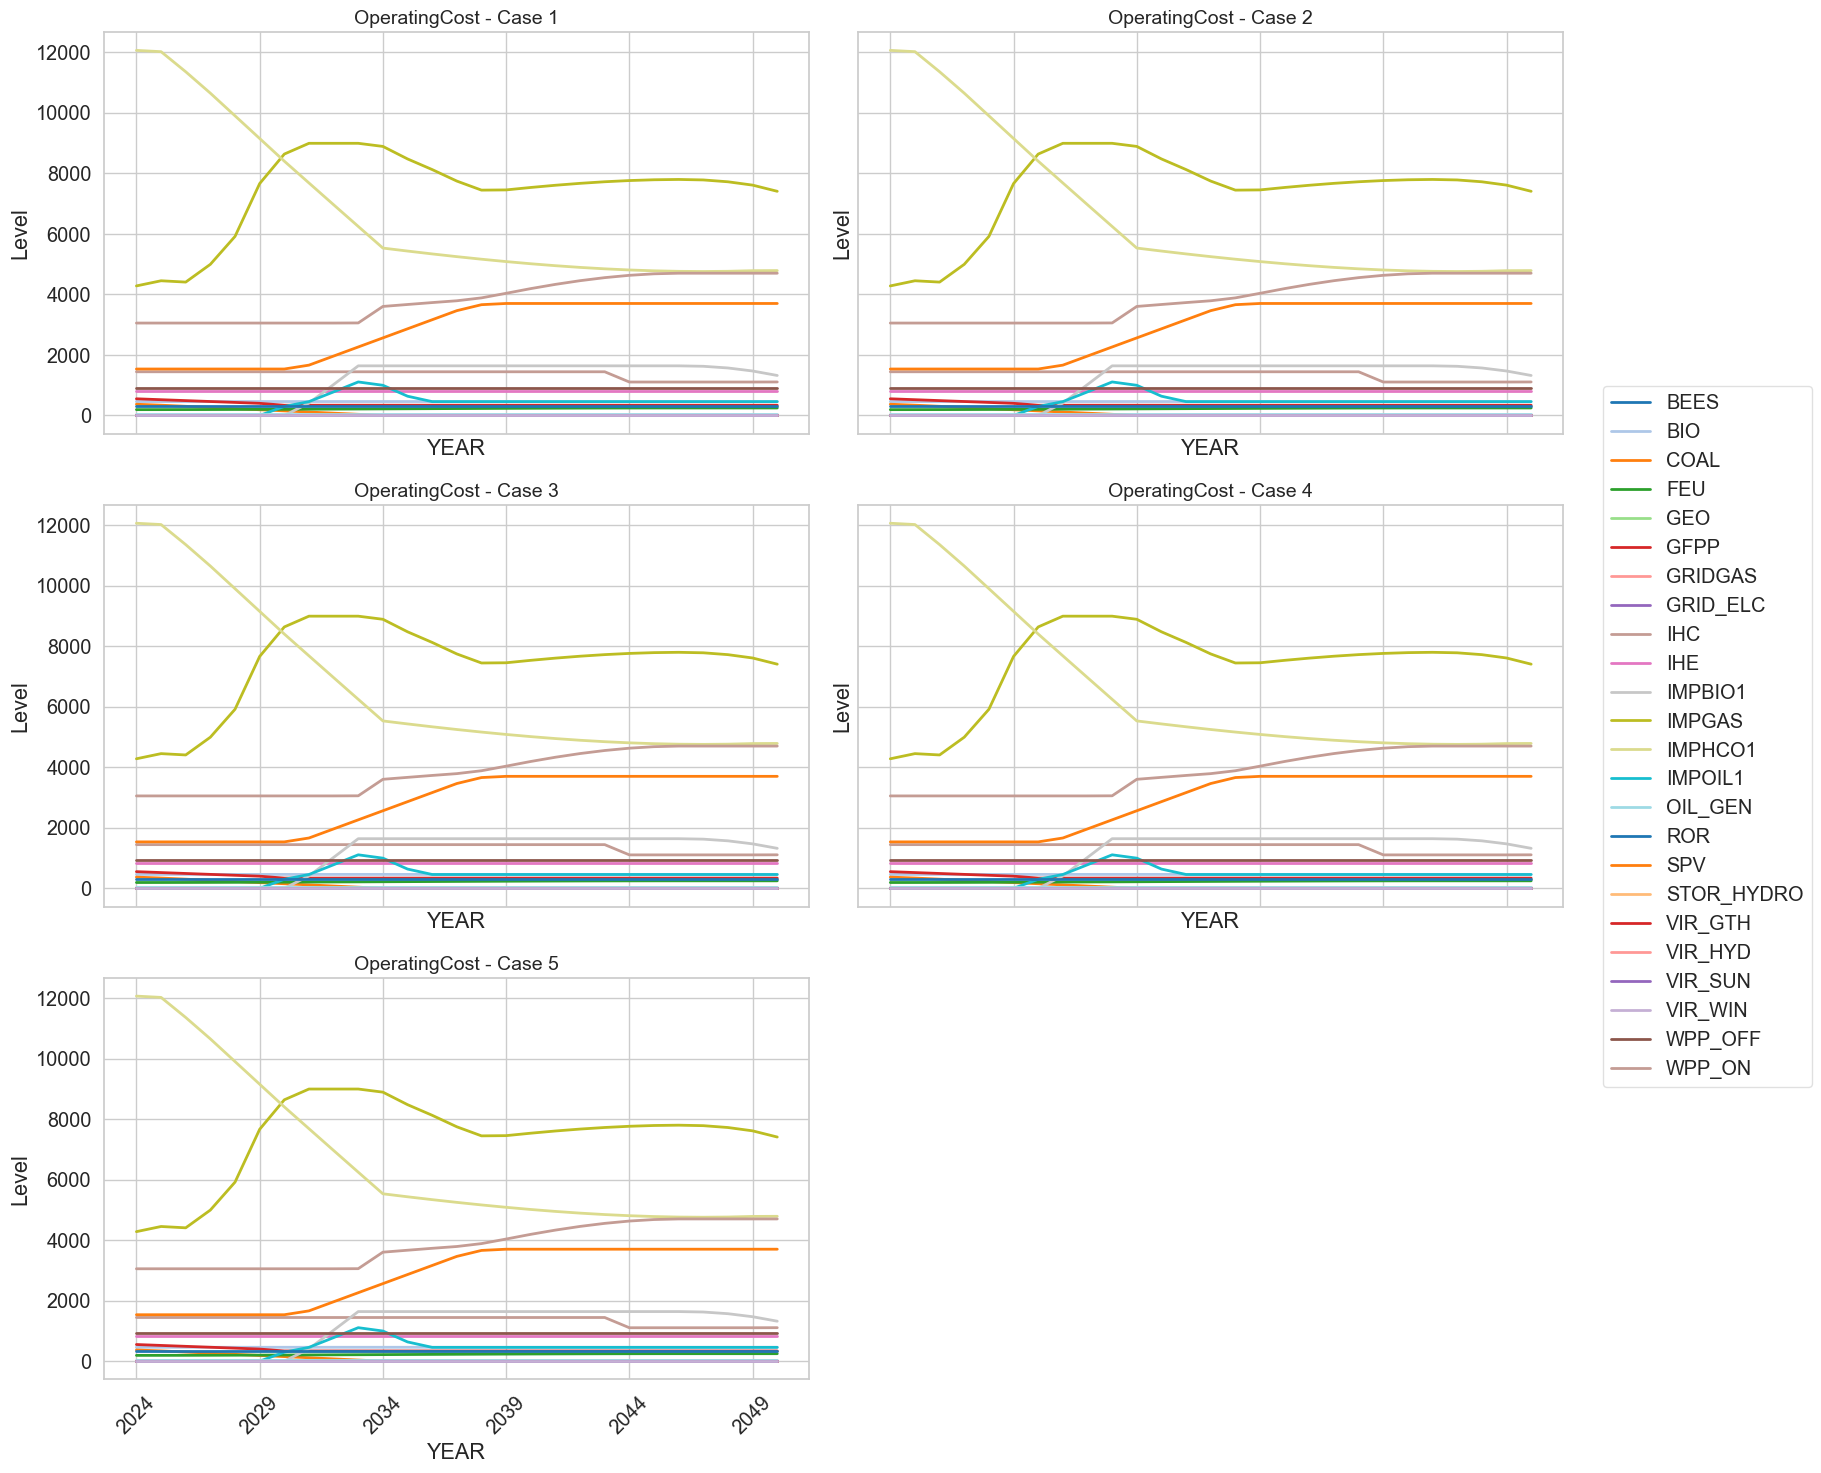

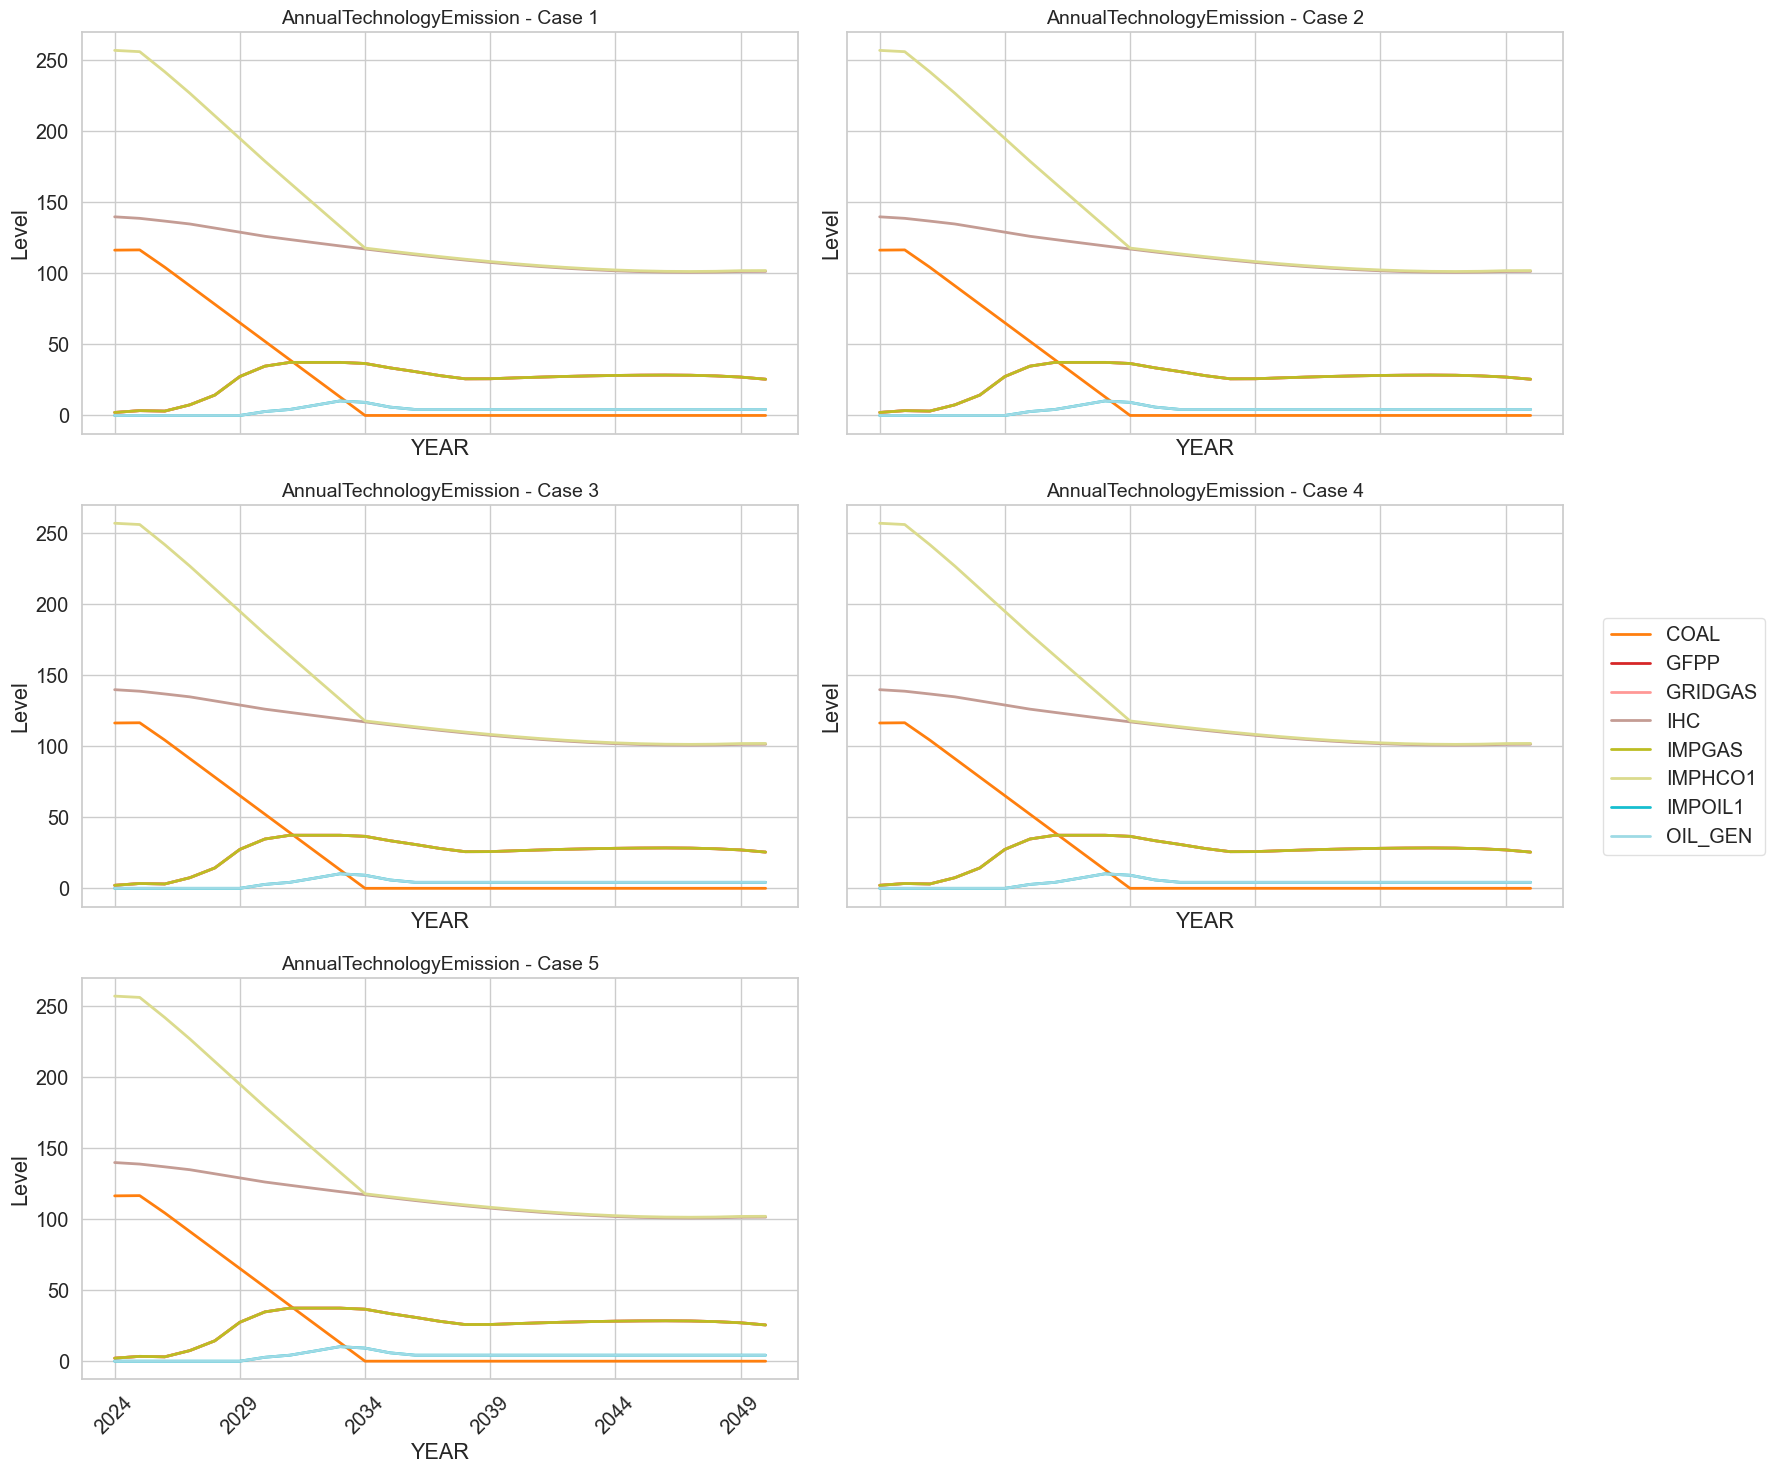

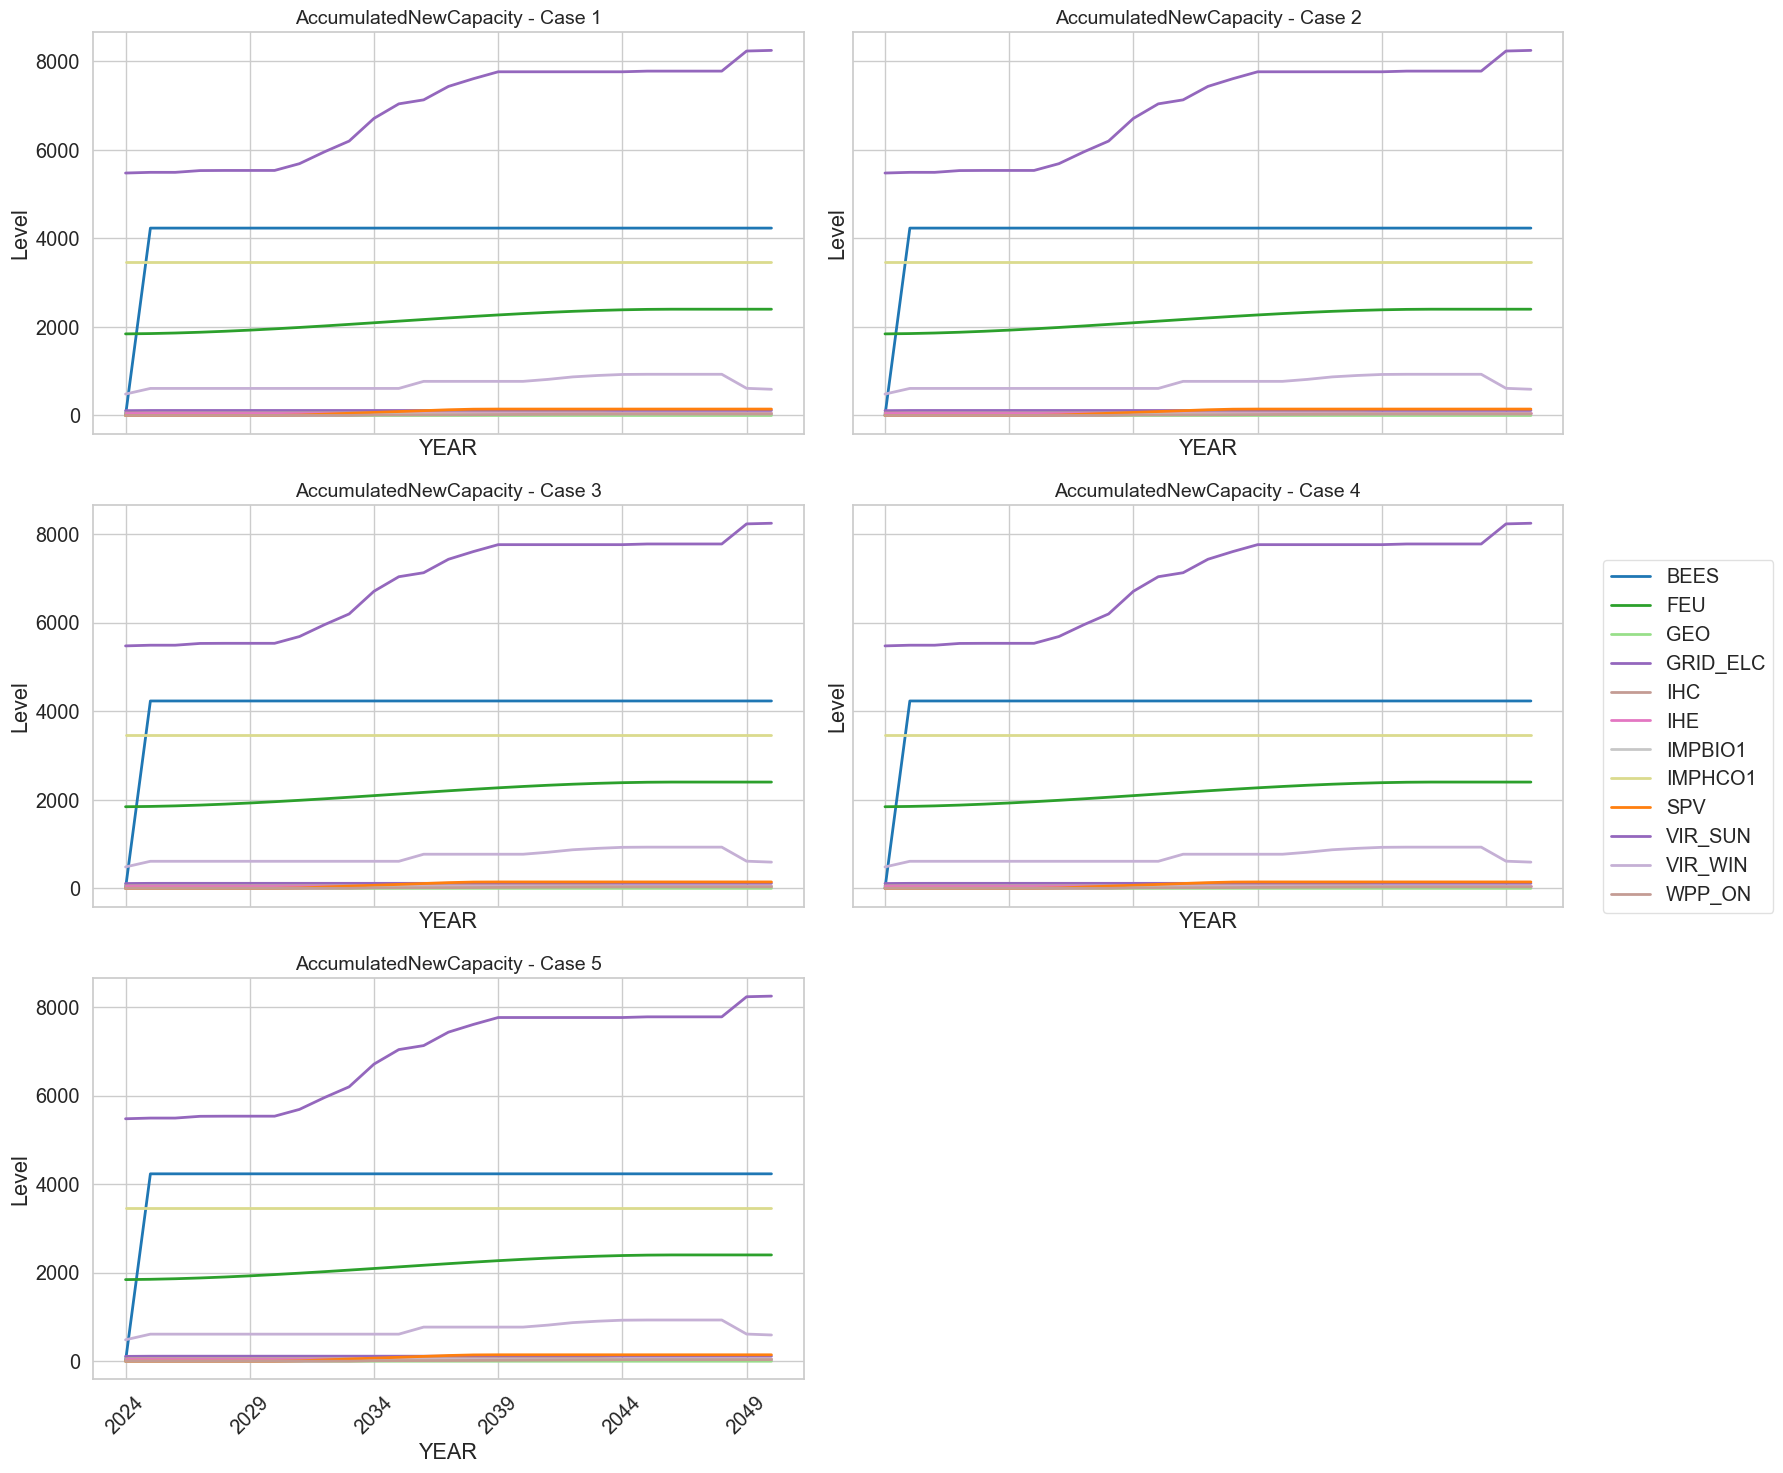

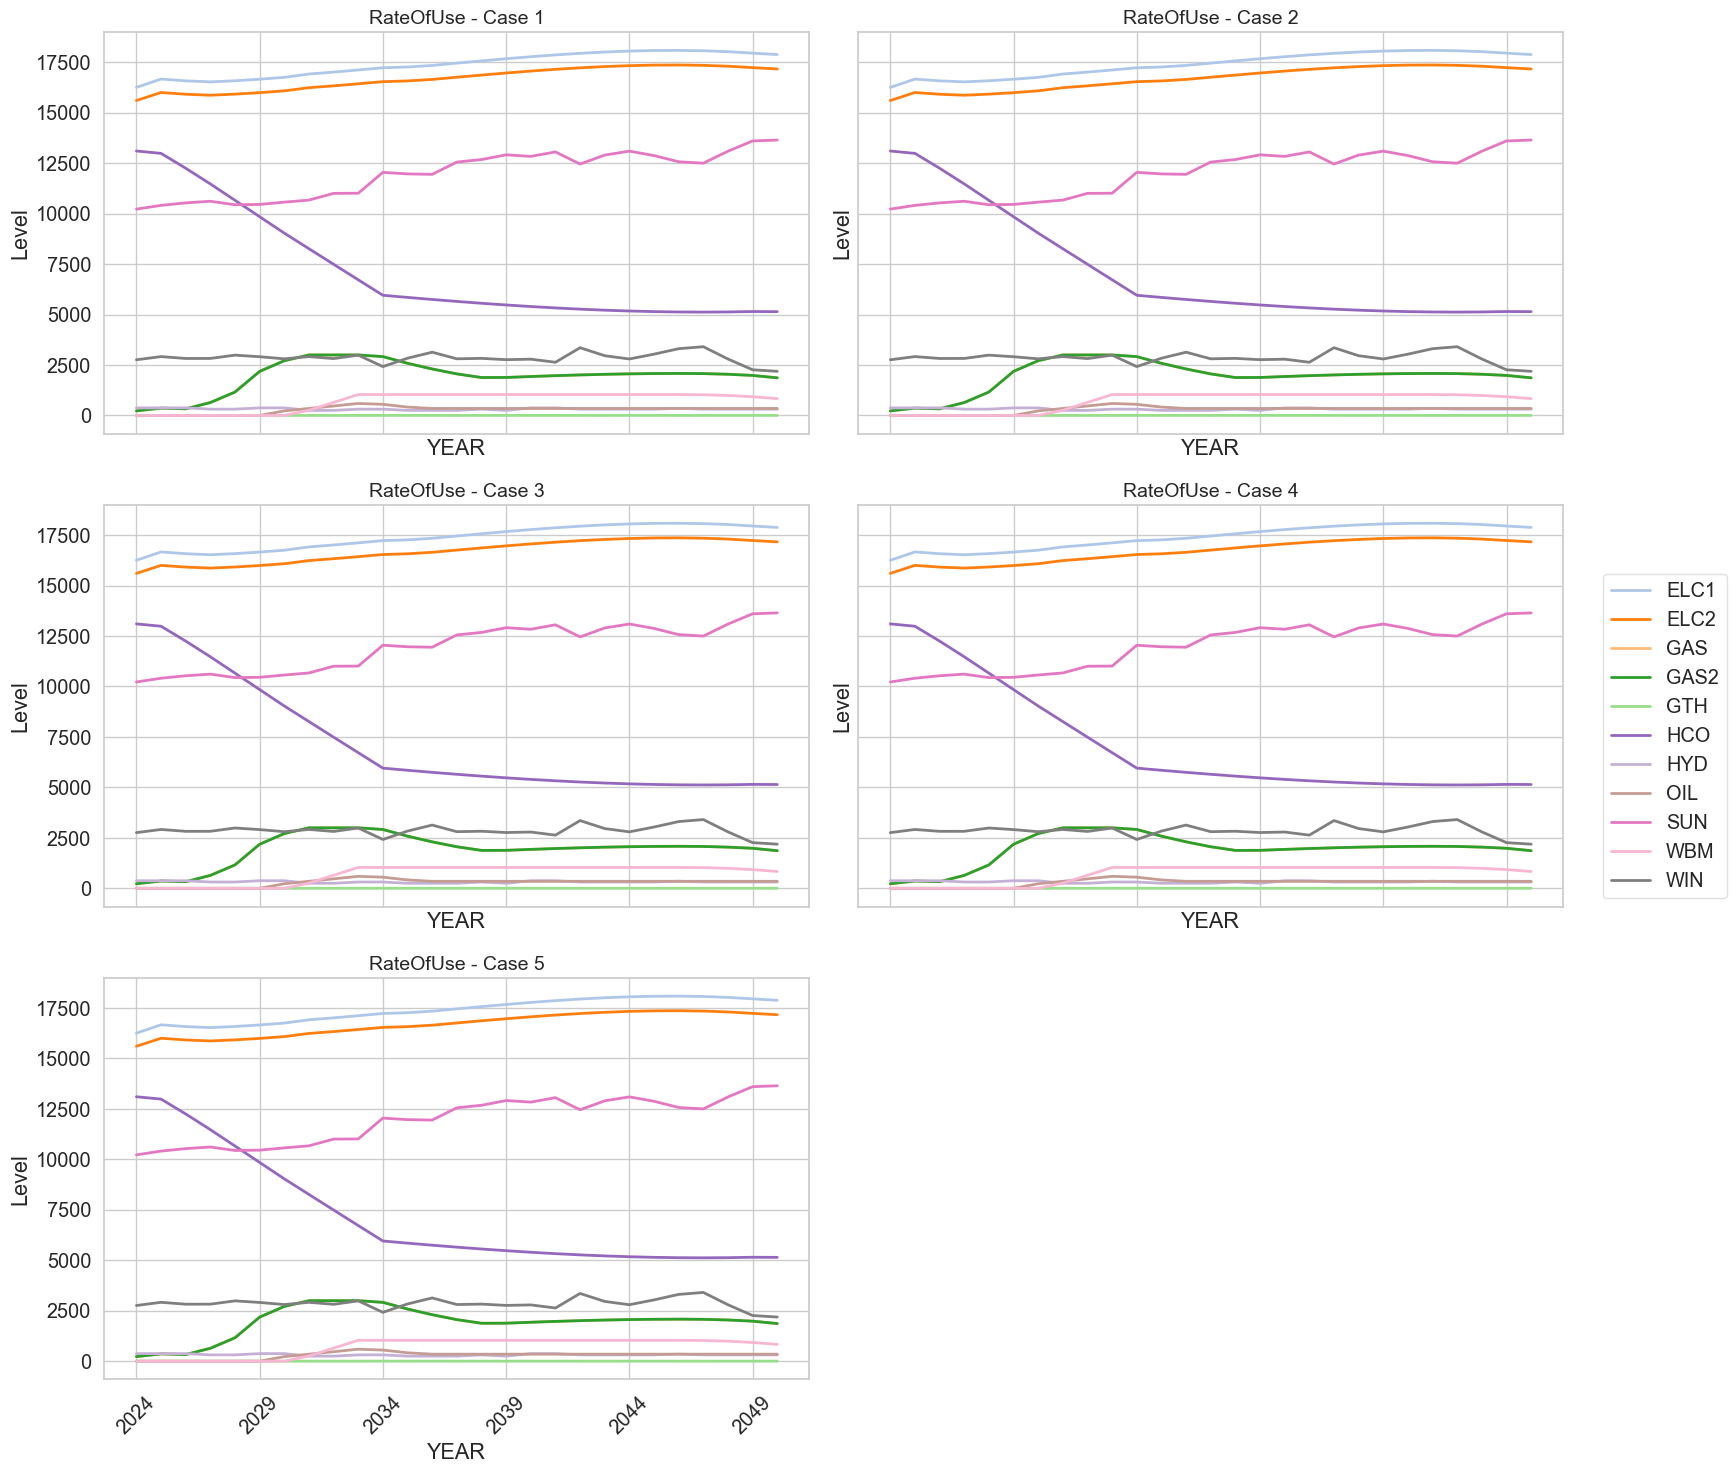

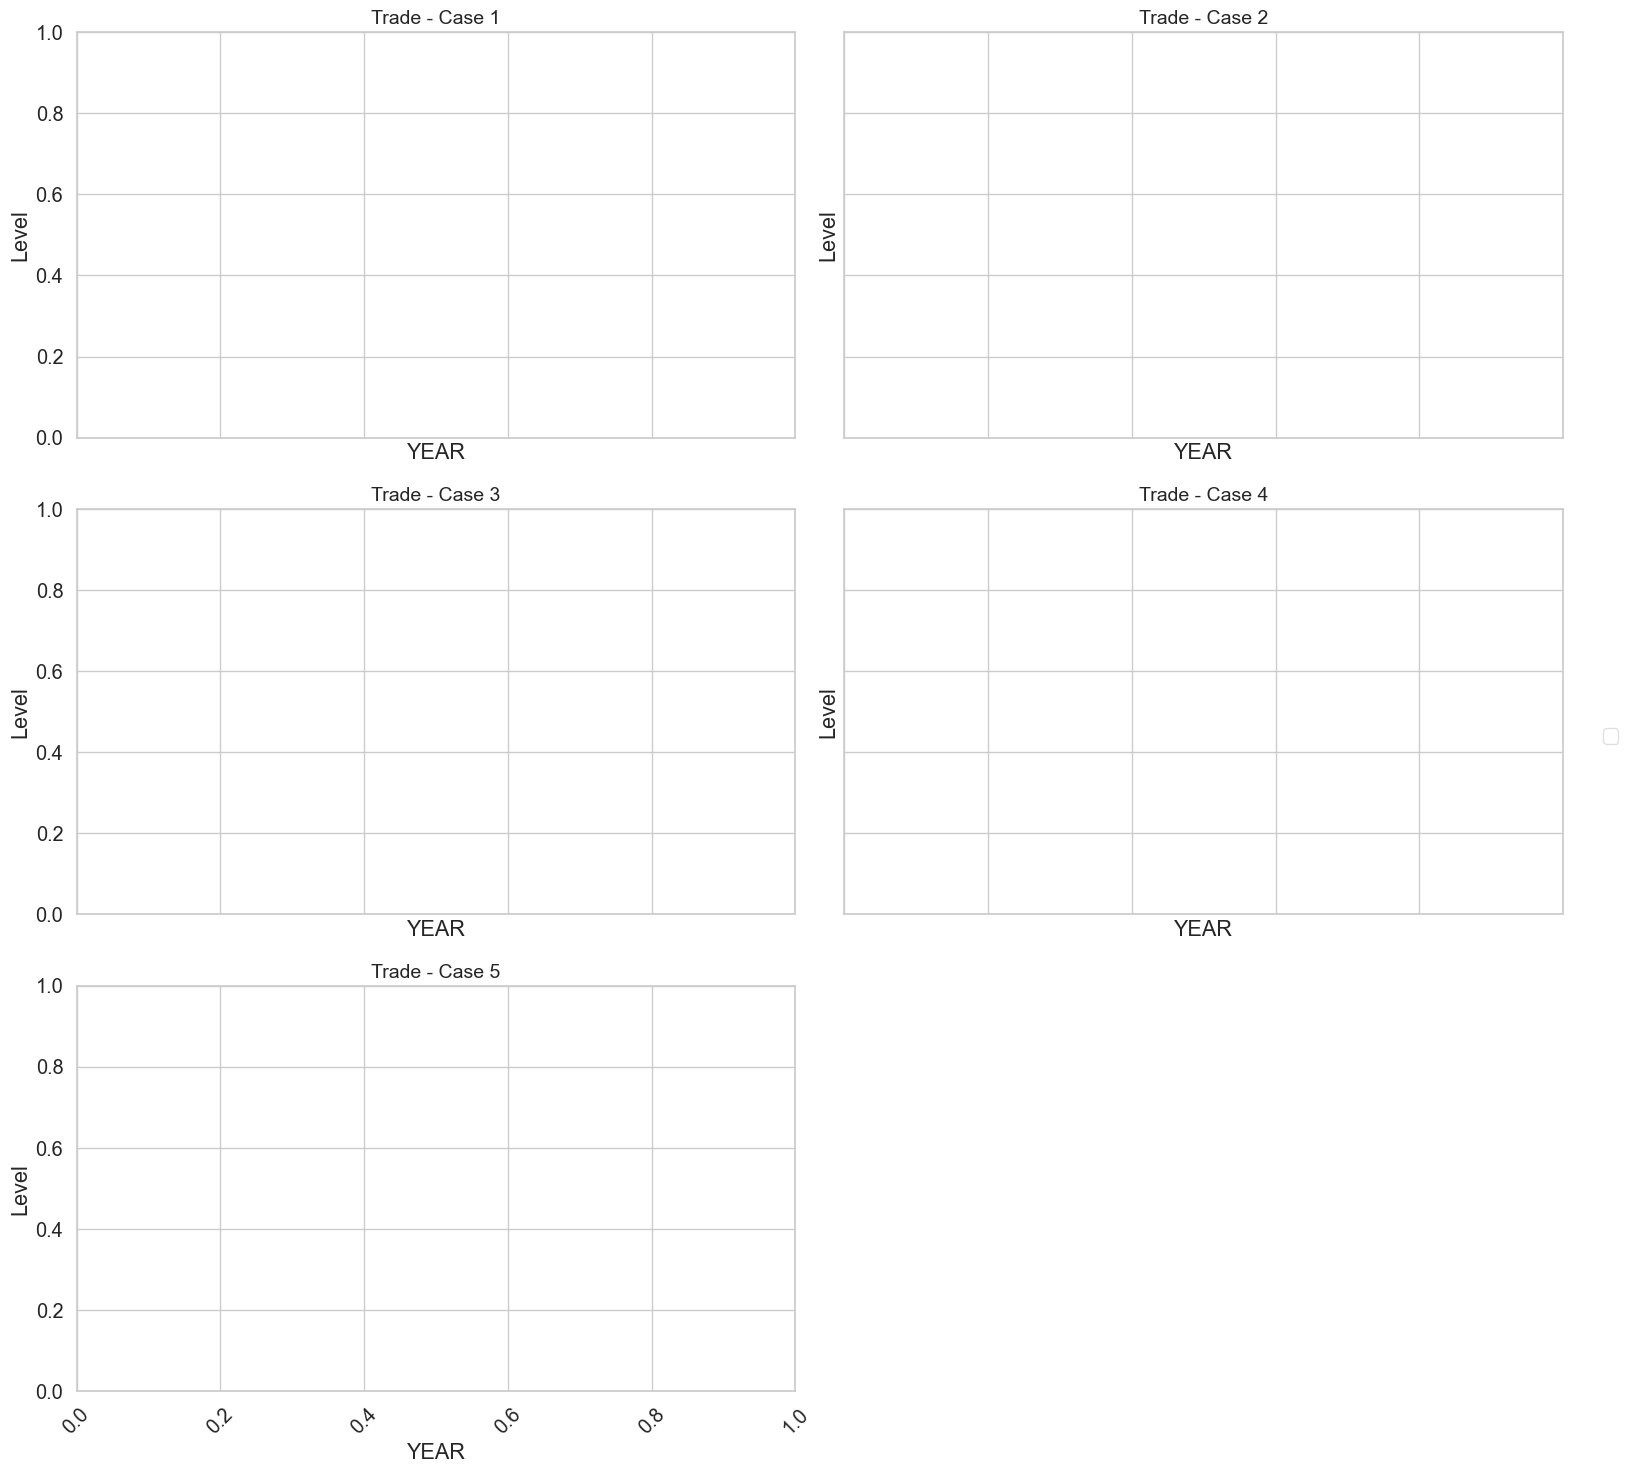

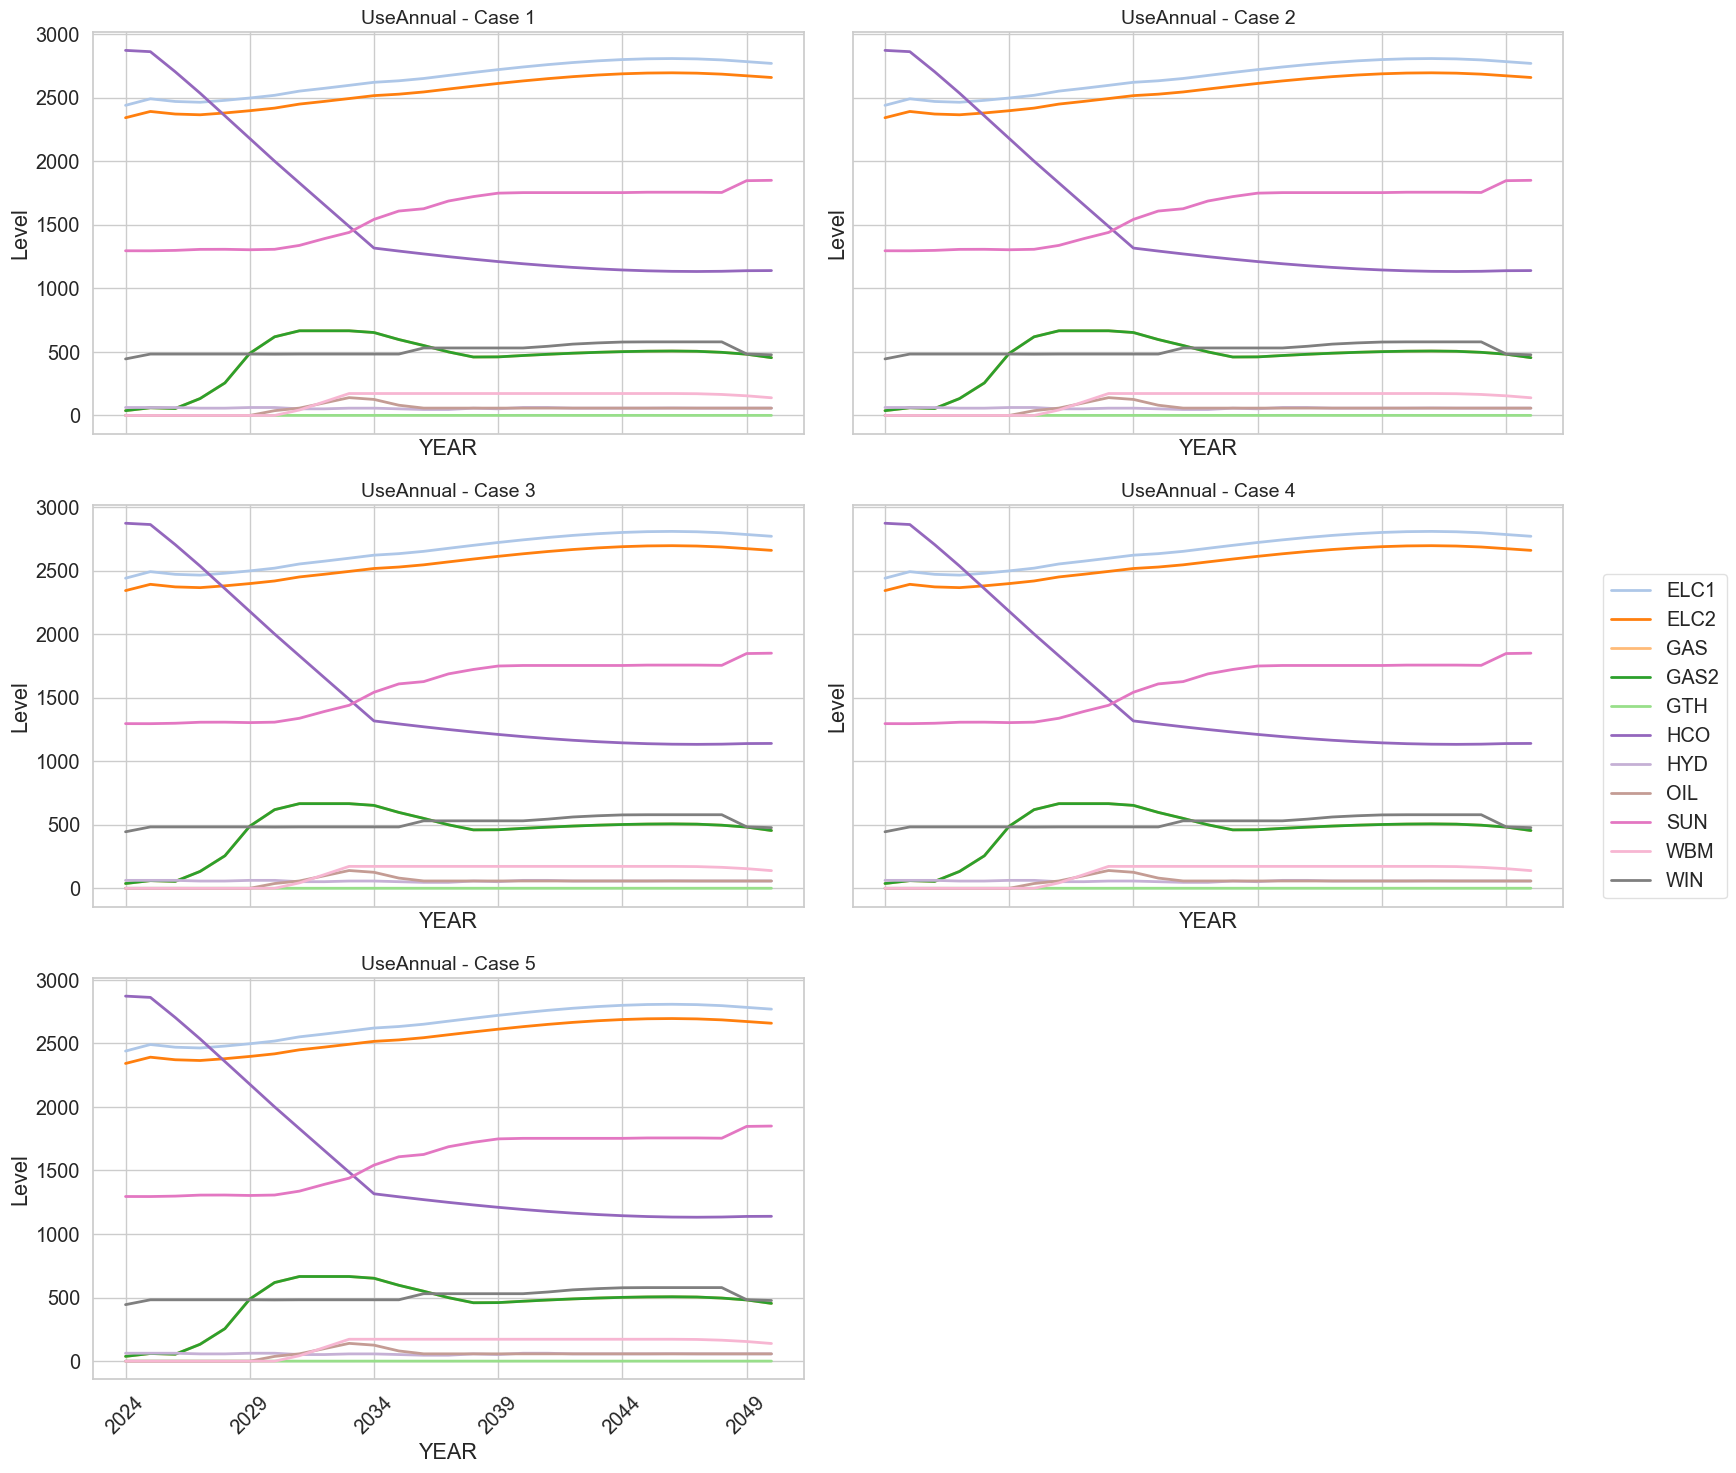

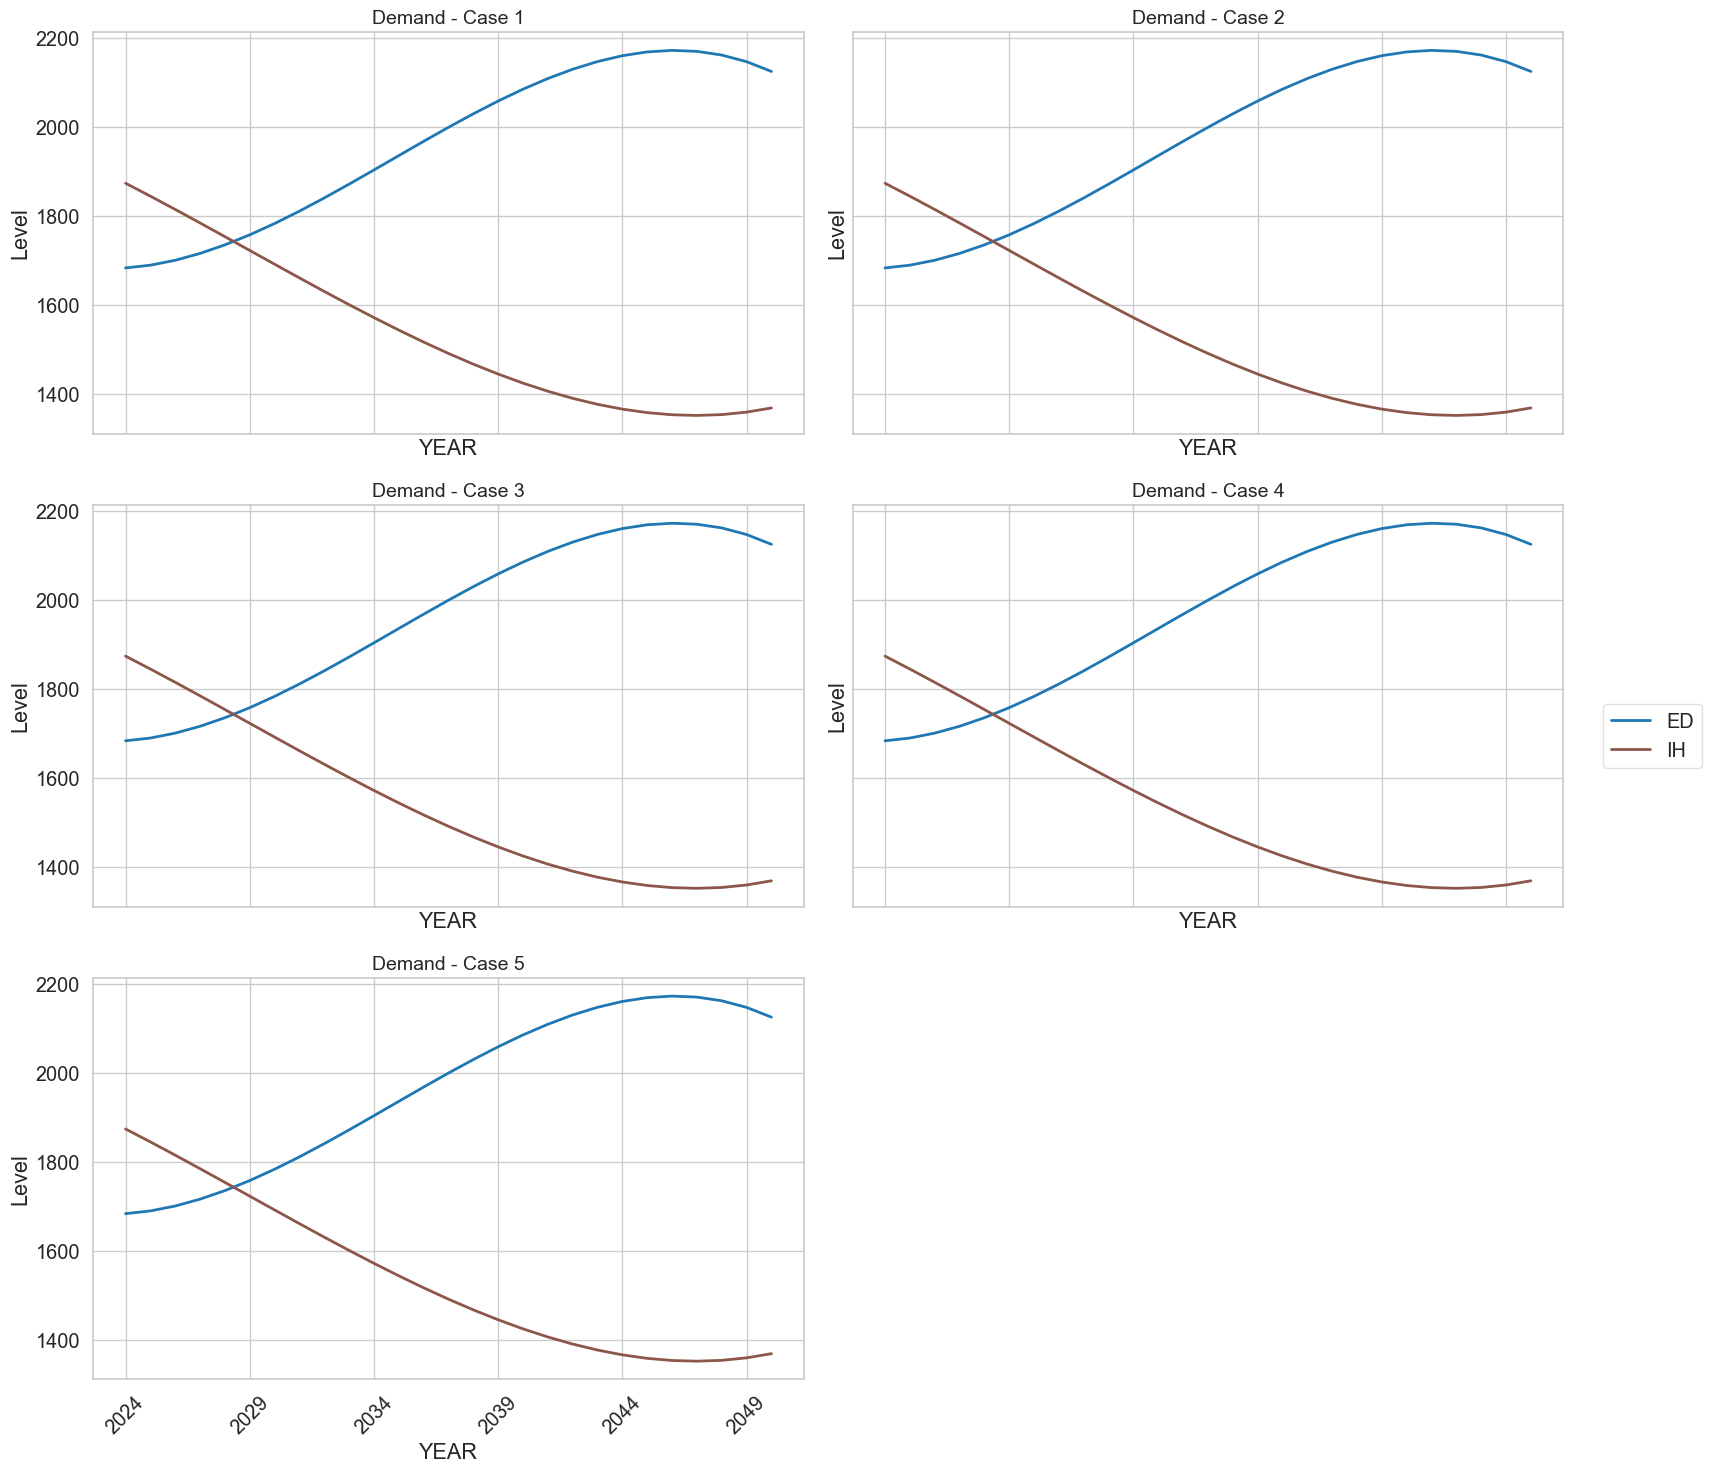

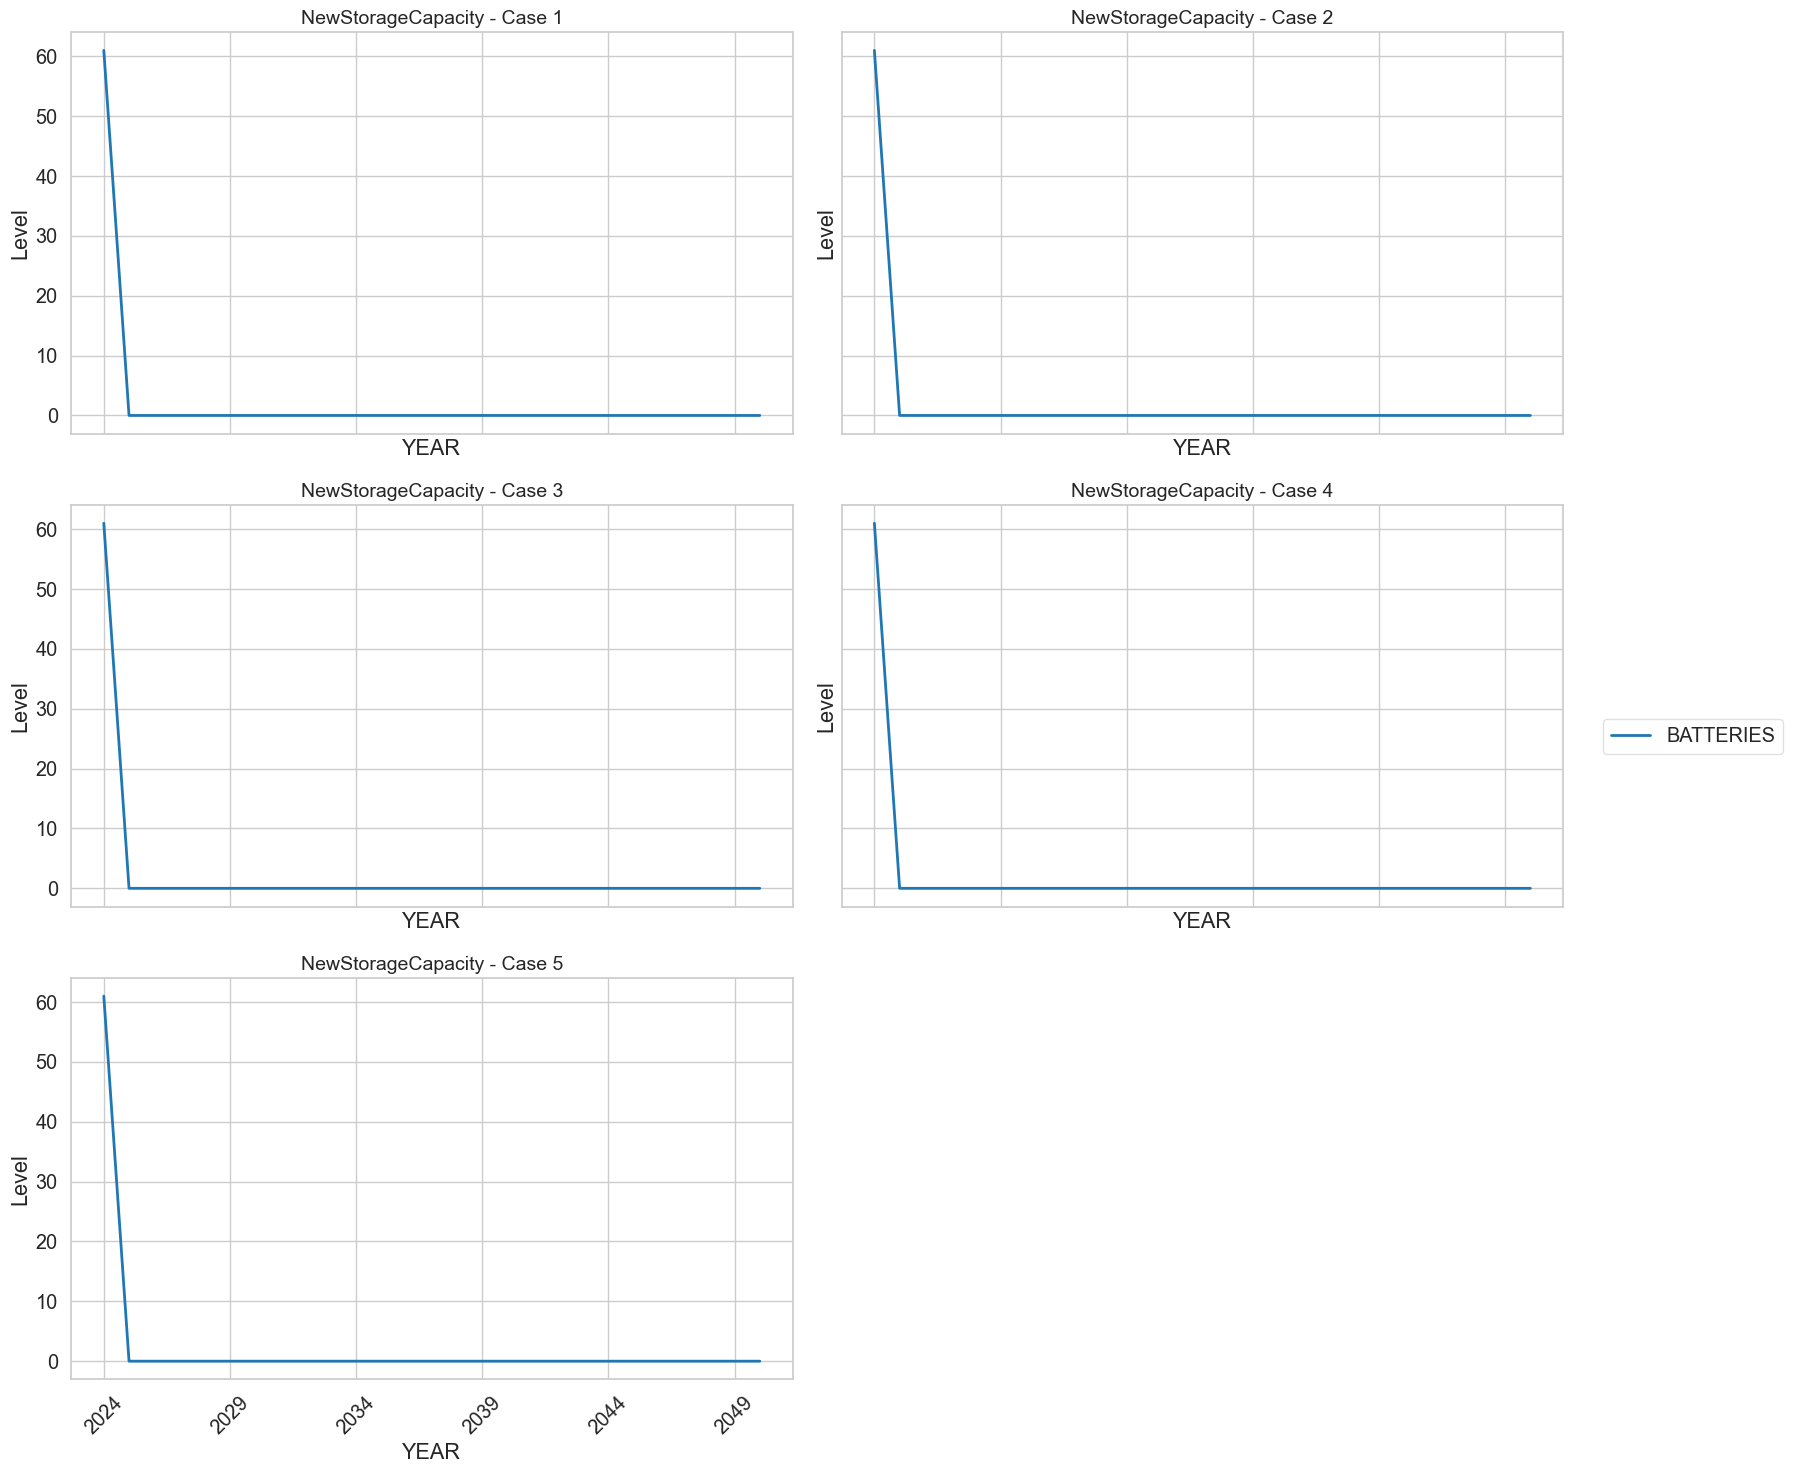

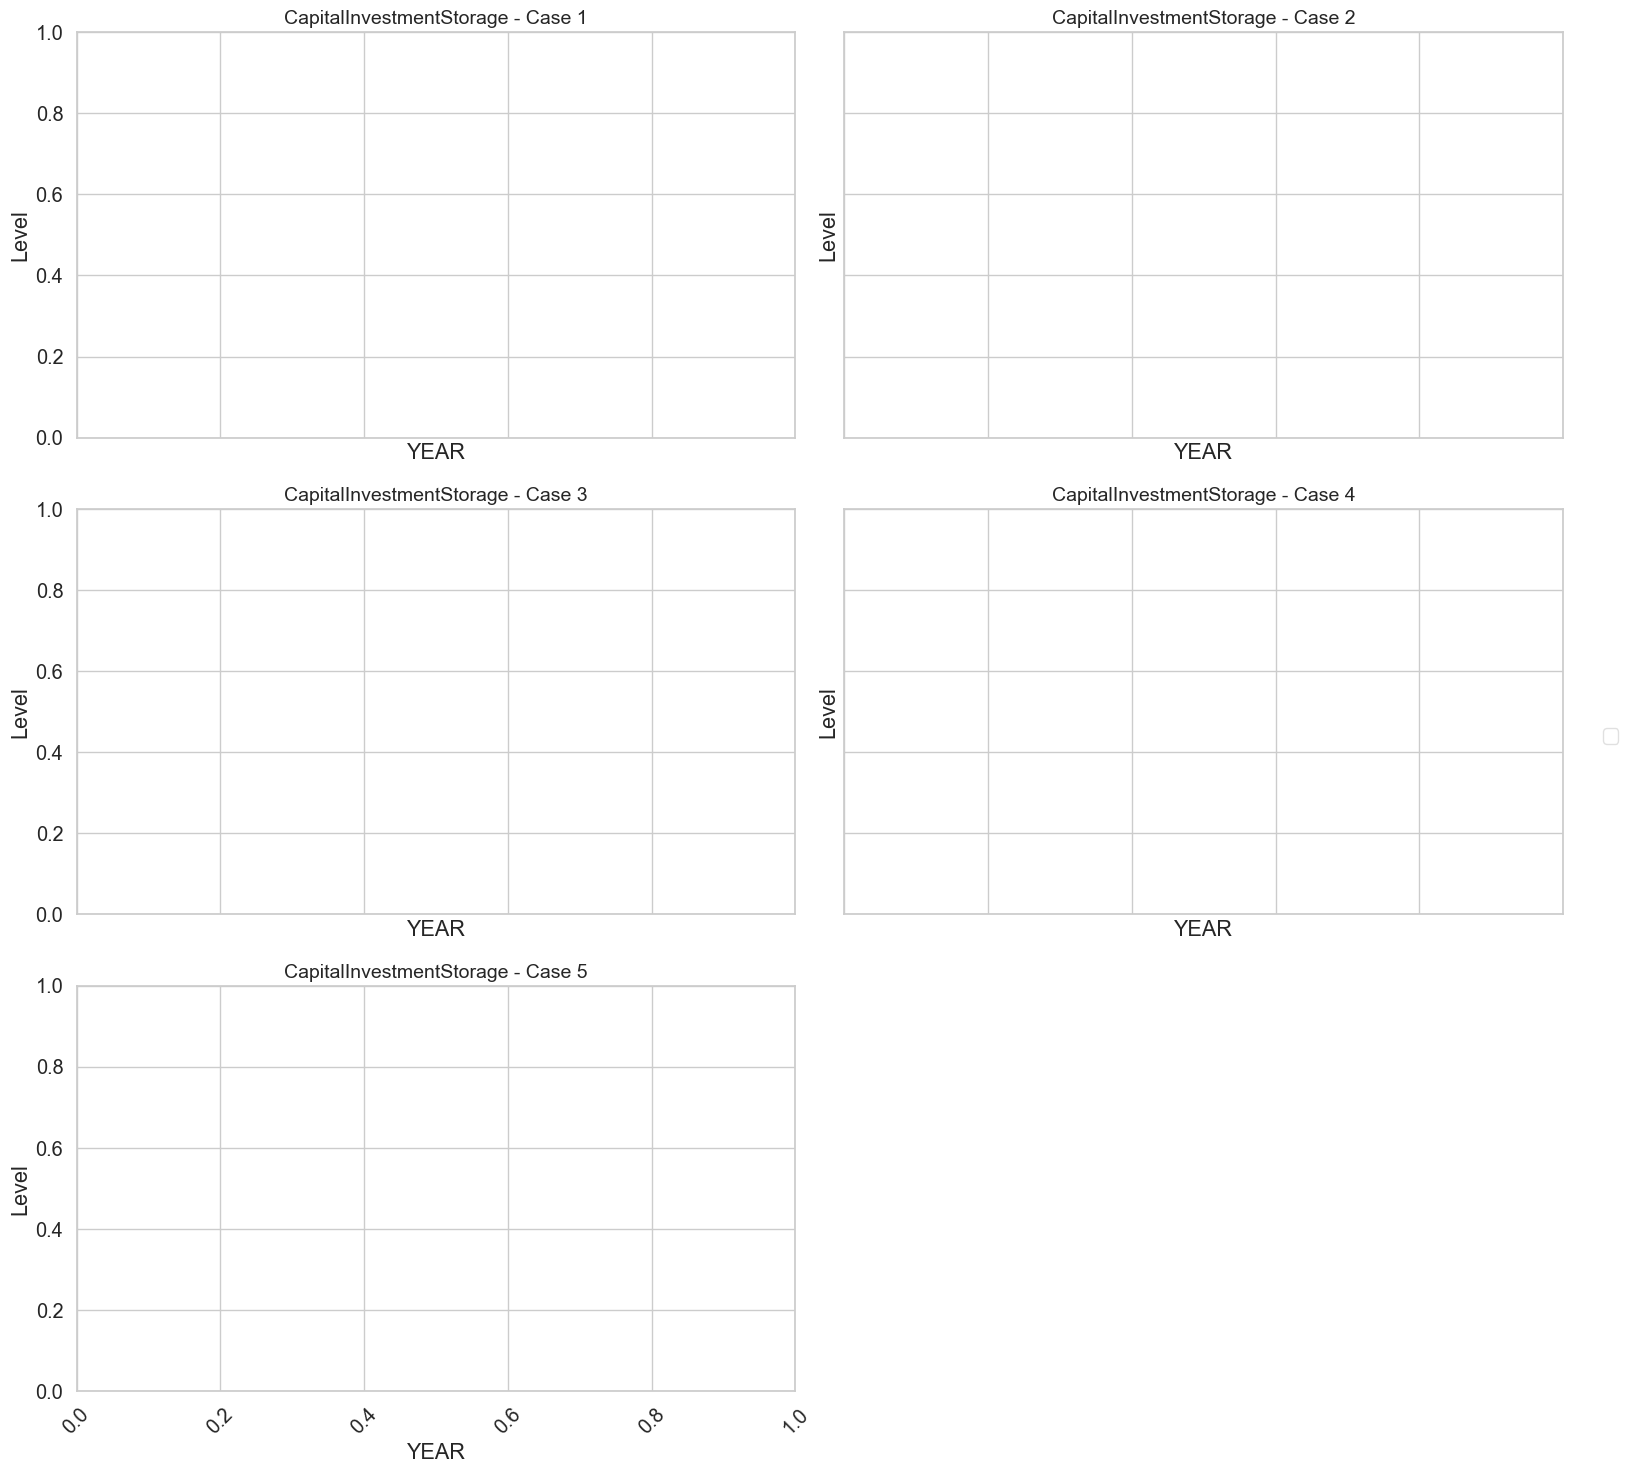

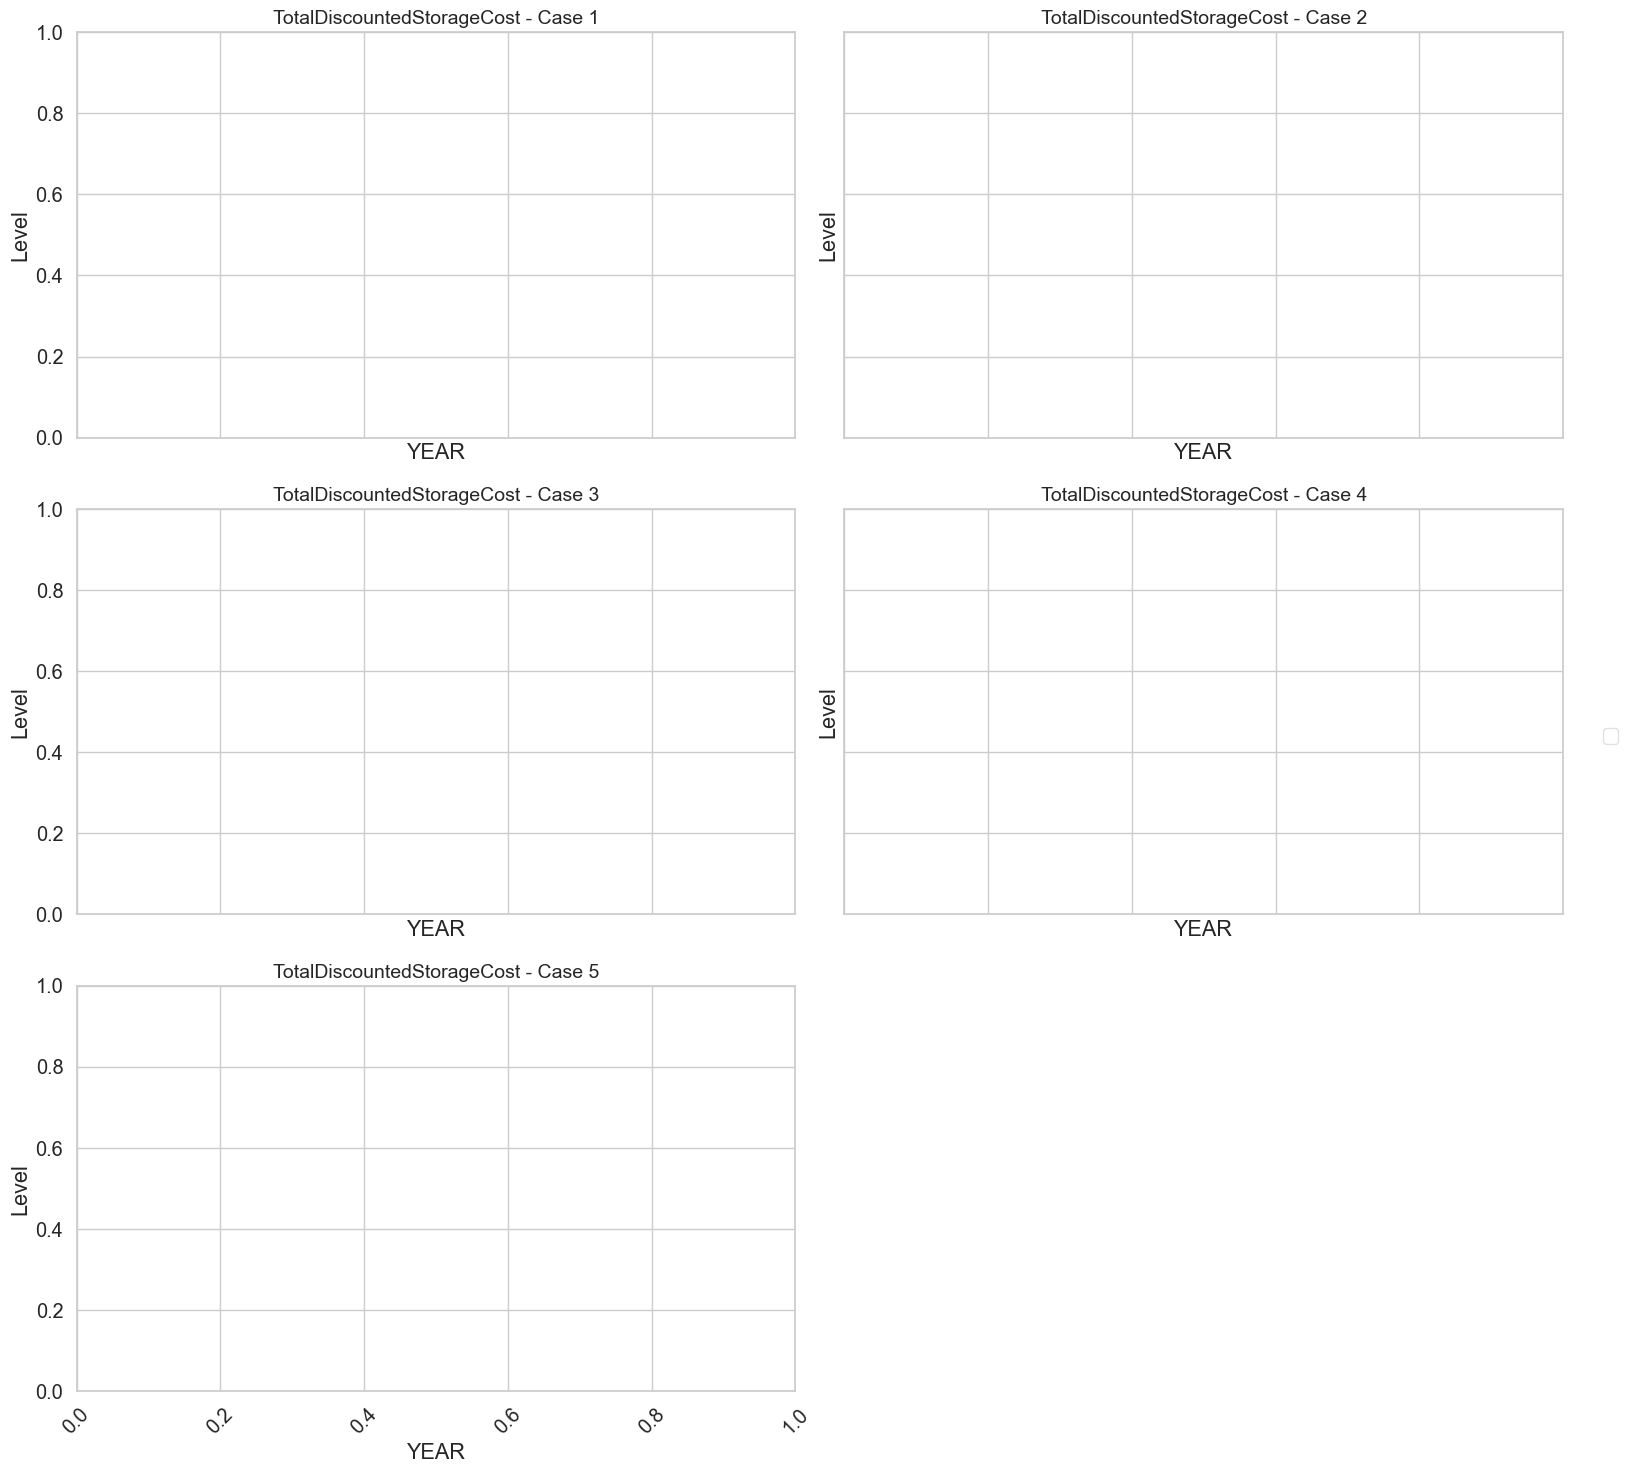

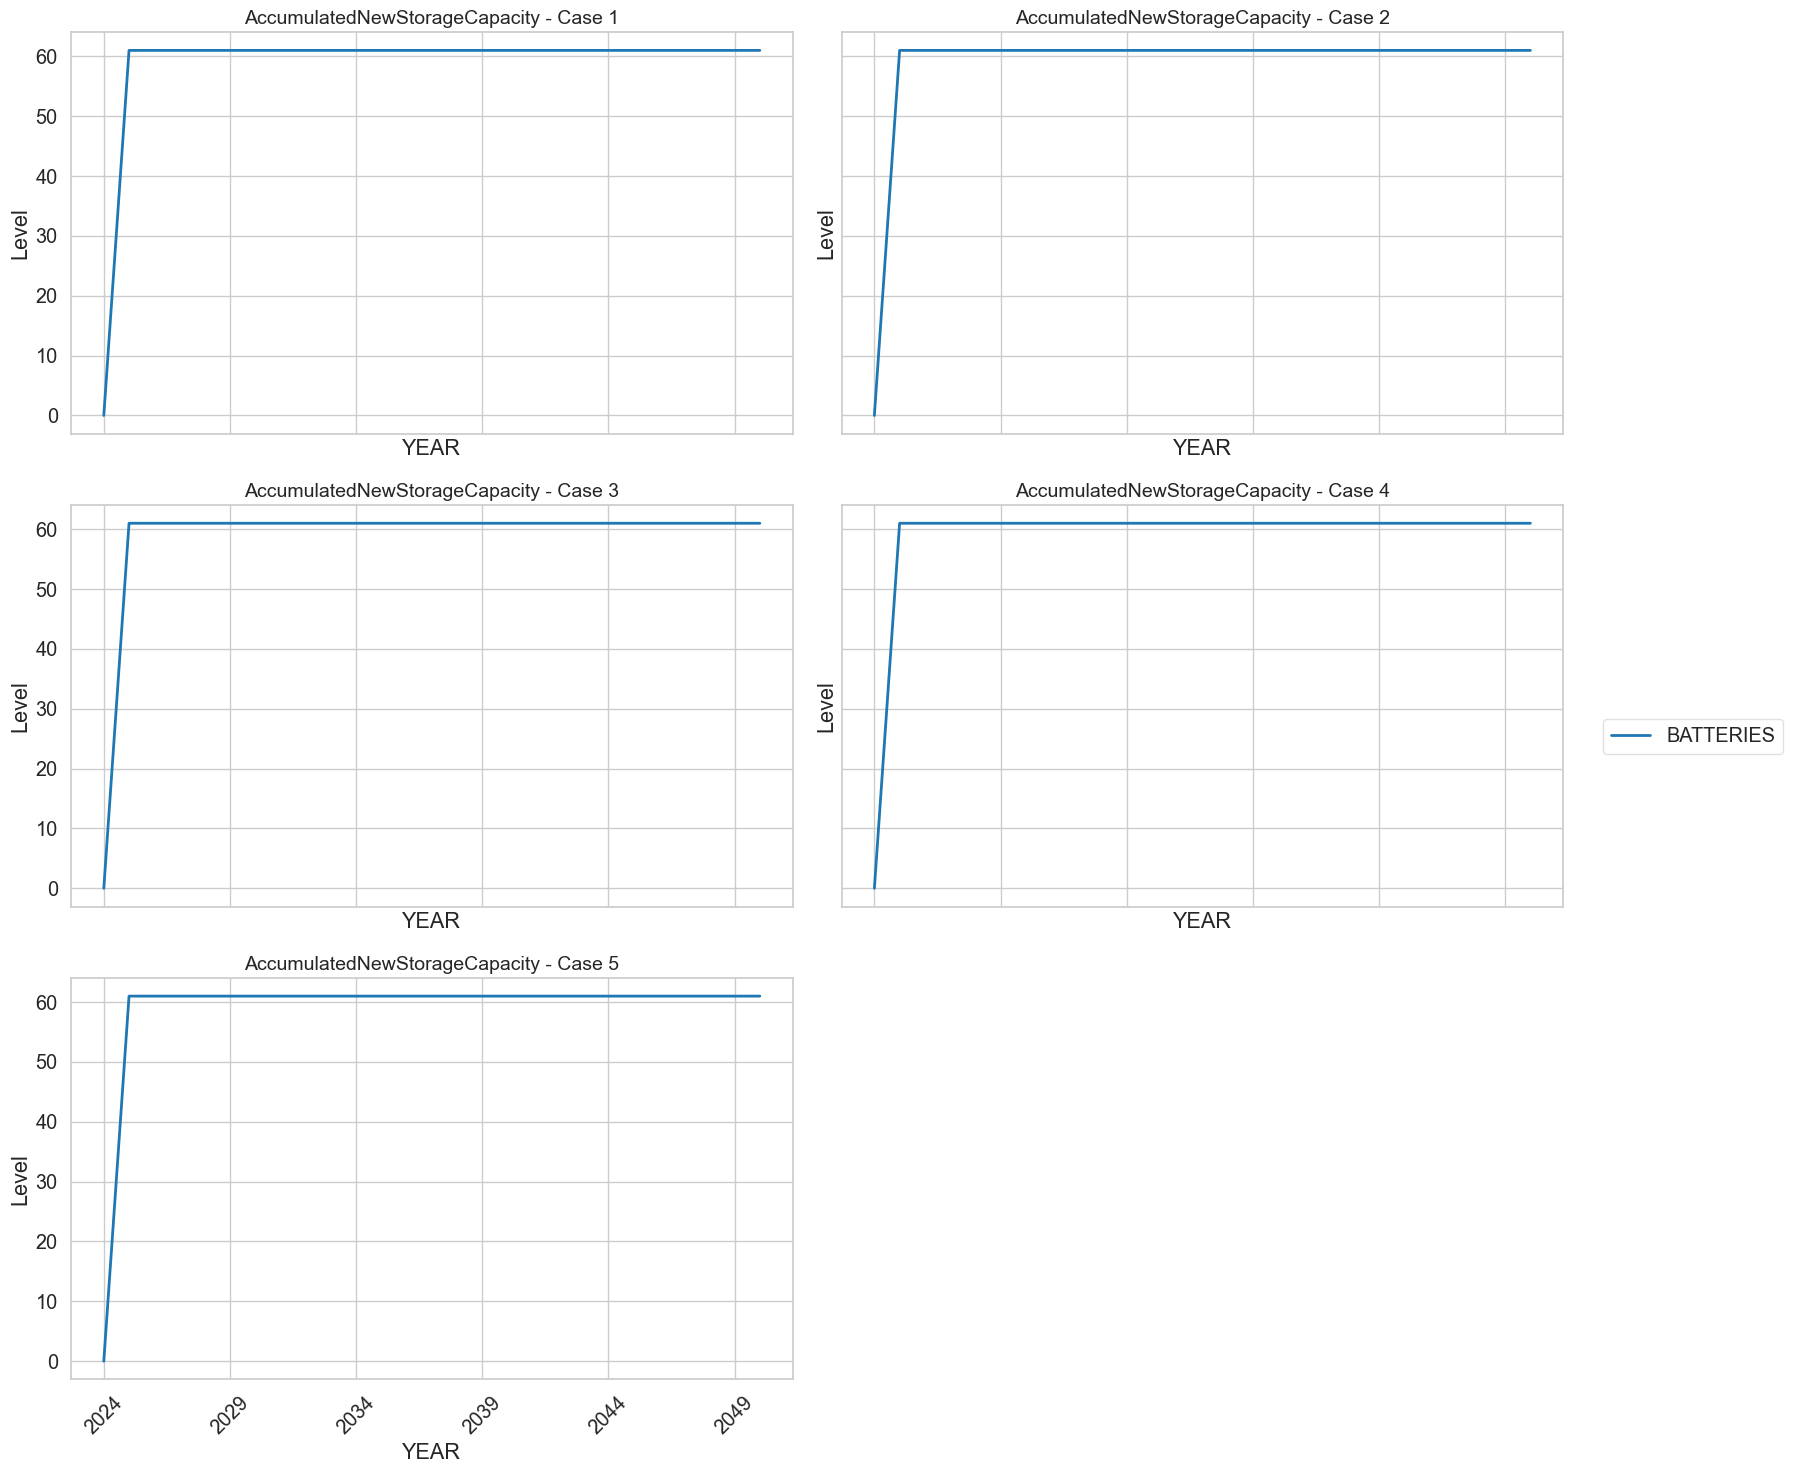

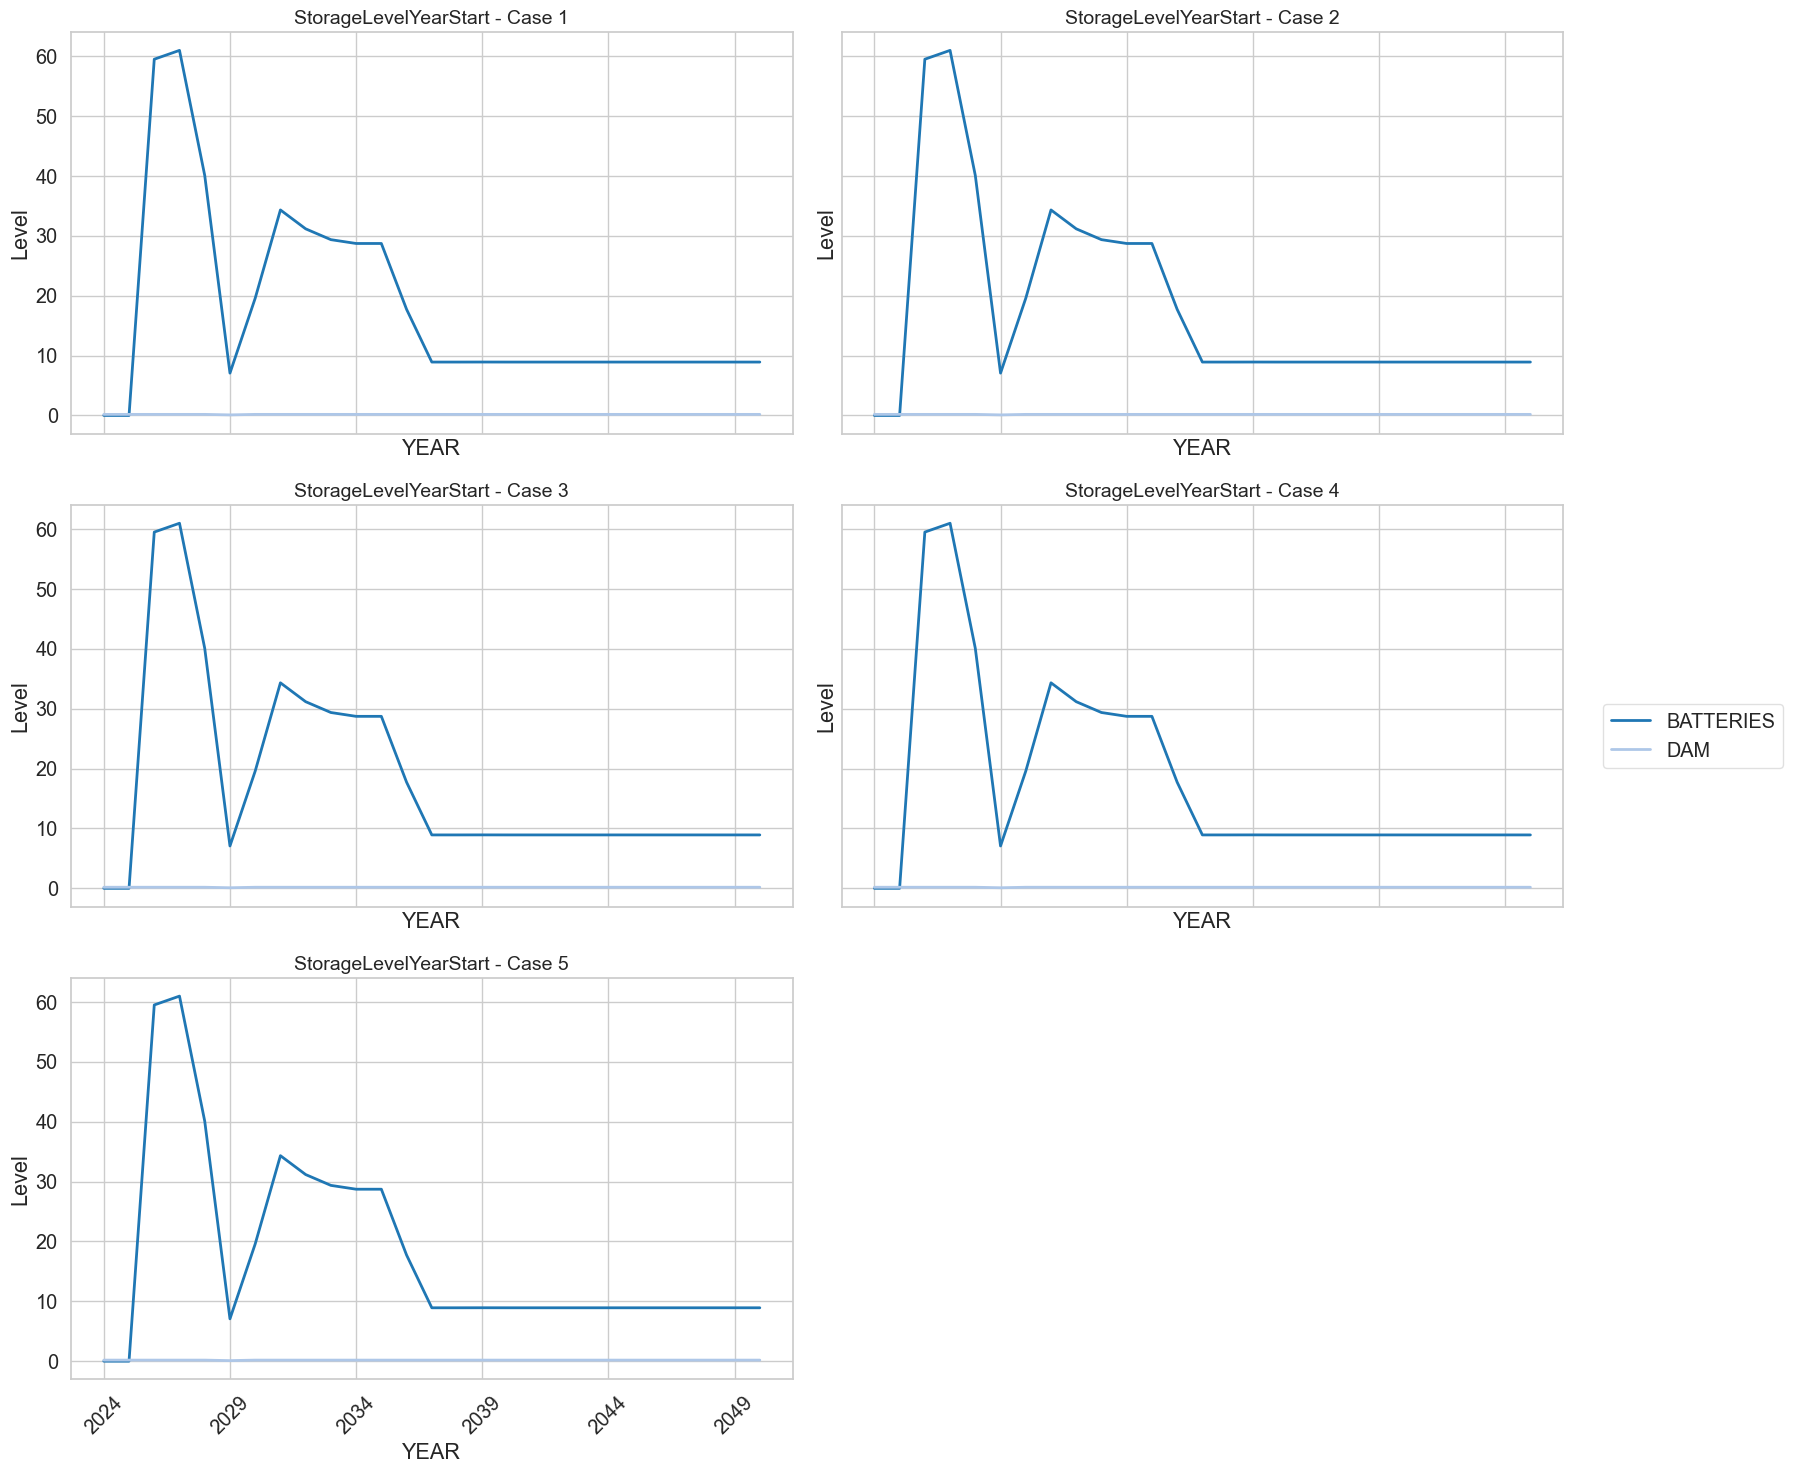

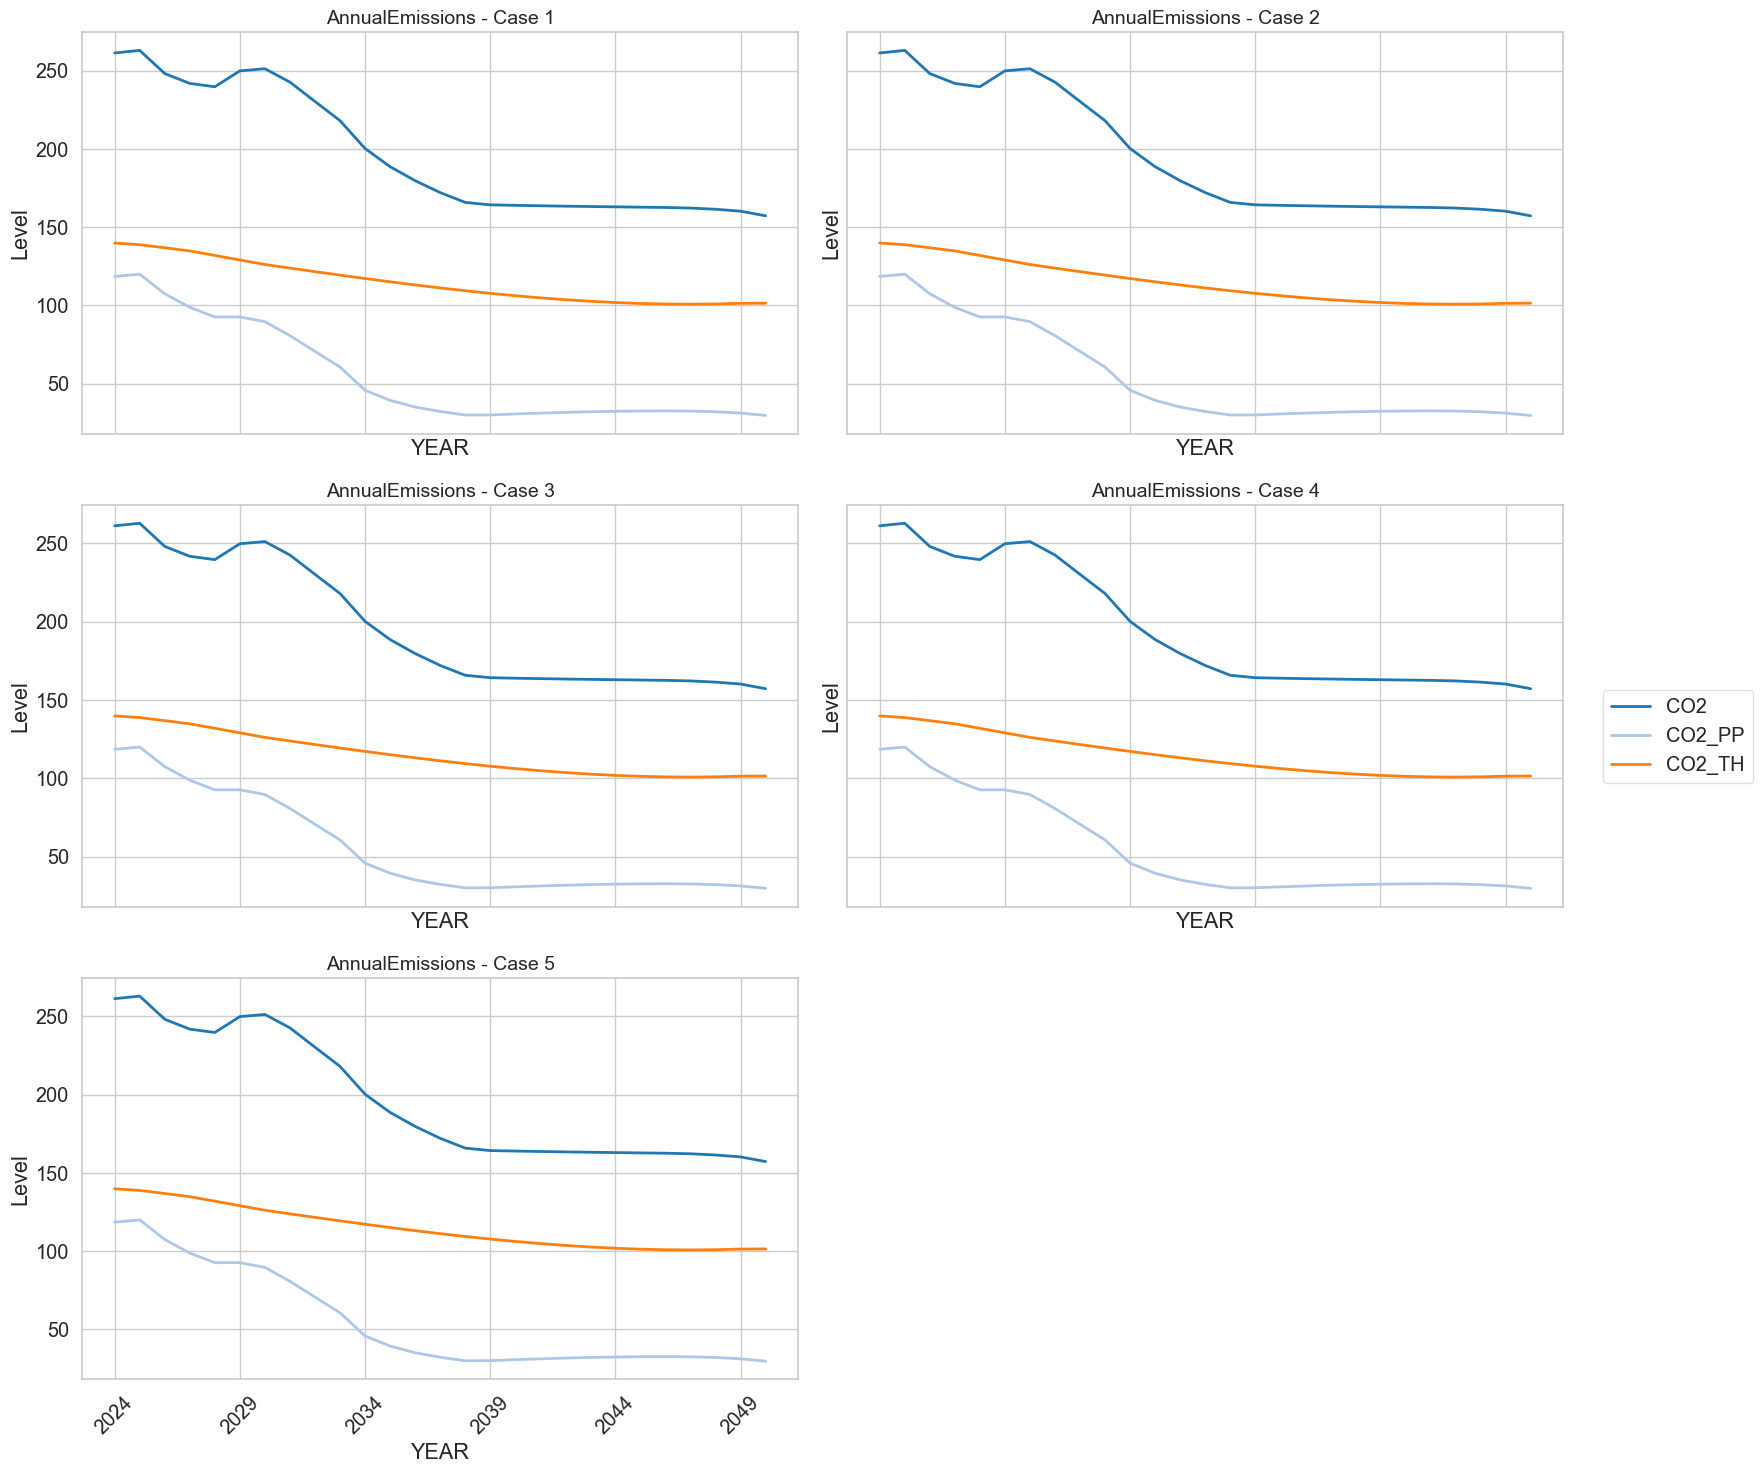

In [38]:
#Example
ssps = run_extr_gams(selected_files, solvermode="mip")

filter_list = None #charts you want to see | None for all

# Plot all useful charts
plot_allusefulcharts(ssps, filter=filter_list)